# Managing Big Data for Connected Devices

## 420-N63-NA

## Kawser Wazed Nafi
 ----------------------------------------------------------------------------------------------------------------------------------

# Data Preprocessing and Selection of Features 
For example, we are going to use the following California Housing data set.

The data contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). In this sample a block group on average includes 1425.5 individuals living in a geographically compact area.

These spatial data contain 20,640 observations on housing prices with 9 economic variables:

#### Longitude
refers to the angular distance of a geographic place north or south of the earth’s equator for each block group

#### Latitude 
refers to the angular distance of a geographic place east or west of the earth’s equator for each block group

#### Housing Median Age
is the median age of the people that belong to a block group. Note that the median is the value that lies at the midpoint of a frequency distribution of observed values
#### Total Rooms
is the total number of rooms in the houses per block group

#### Total Bedrooms
is the total number of bedrooms in the houses per block group

#### Population
is the number of inhabitants of a block group

#### Households
refers to units of houses and their occupants per block group

#### Median Income
is used to register the median income of people that belong to a block group

#### Median House Value
is the dependent variable and refers to the median house value per block group

### Initialize the Spark Session and Importing the Libraries

In [1]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, VectorIndexer, IndexToString
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

# Spark Session Creation

ss = SparkSession.builder.master("local[4]").appName("Logistic-Regression").getOrCreate()
sc = ss.sparkContext
sqlContext = SQLContext(sc)

# Load data from file into dataframe
HOUSING_DATA = 'input/cal_housing.data'
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)
# Load housing data
housing_df = ss.read.csv(path=HOUSING_DATA, schema=schema).cache()

# Inspect first five rows
housing_df.take(5)

# show the dataframe columns
housing_df.columns

# show the schema of the dataframe
#housing_df.printSchema()

# run a sample selection
housing_df.select('pop','totbdrms').show(10)

# group by housingmedianage and see the distribution
result_df = housing_df.groupBy("medage").count().sort("medage", ascending=False)

result_df.show(10)

/usr/local/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+------+--------+
|   pop|totbdrms|
+------+--------+
| 322.0|   129.0|
|2401.0|  1106.0|
| 496.0|   190.0|
| 558.0|   235.0|
| 565.0|   280.0|
| 413.0|   213.0|
|1094.0|   489.0|
|1157.0|   687.0|
|1206.0|   665.0|
|1551.0|   707.0|
+------+--------+
only showing top 10 rows

+------+-----+
|medage|count|
+------+-----+
|  52.0| 1273|
|  51.0|   48|
|  50.0|  136|
|  49.0|  134|
|  48.0|  177|
|  47.0|  198|
|  46.0|  245|
|  45.0|  294|
|  44.0|  356|
|  43.0|  353|
+------+-----+
only showing top 10 rows



## Data Preprocessing
With all this information that we gathered from our small exploratory data analysis, we know enough to preprocess our data to feed it to the model.

1. we shouldn't care about missing values; all zero values have been excluded from the data set.
2. We should probably standardize our data, as we have seen that the range of minimum and maximum values is quite big.
3. There are possibly some additional attributes that we could add, such as a feature that registers the number of bedrooms per room or the rooms per household.
4. Our dependent variable is also quite big; To make our life easier, we'll have to adjust the values slightly.

#### Preprocessing The Target Values
First, let's start with the medianHouseValue, our dependent variable. To facilitate our working with the target values, we will express the house values in units of 100,000. That means that a target such as 452600.000000 should become 4.526:

### Feature Engineering / Selection from Sample

Now that we have adjusted the values in medianHouseValue, we will now add the following columns to the data set:

1. Rooms per household which refers to the number of rooms in households per block group;
2. Population per household, which basically gives us an indication of how many people live in households per block group; And
3. Bedrooms per room which will give us an idea about how many rooms are bedrooms per block group;

As we're working with DataFrames, we can best use the select() method to select the columns that we're going to be working with, namely totalRooms, households, and population. Additionally, we have to indicate that we're working with columns by adding the col() function to our code. Otherwise, we won't be able to do element-wise operations like the division that we have in mind for these three variables:



In [2]:
# Summary of the data

(housing_df.describe().select(
                    "summary",
                    F.round("medage", 4).alias("medage"),
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv"))
                    .show())

+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20640.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631| 537.898|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.2479|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+



In [3]:
# Adjust the values of `medianHouseValue`
housing_df = housing_df.withColumn("medhv", col("medhv")/100000)
housing_df.show(2)

housing_df.columns

# Add the new columns to `df`
housing_df = (housing_df.withColumn("rmsperhh", F.round(col("totrooms")/col("houshlds"), 2))
                       .withColumn("popperhh", F.round(col("pop")/col("houshlds"), 2))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms")/col("totrooms"), 2)))

# Inspect the result
housing_df.show(10)

+-------+-----+------+--------+--------+------+--------+------+-----+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|
+-------+-----+------+--------+--------+------+--------+------+-----+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|
+-------+-----+------+--------+--------+------+--------+------+-----+
only showing top 2 rows



['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|    6.98|    2.56|      0.15|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|    6.24|    2.11|      0.16|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|    8.29|     2.8|      0.13|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|3.413|    5.82|    2.55|      0.18|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|3.422|    6.28|    2.18|      0.17|
|-122.25|37.85|  52.0|   919.0|   213.0| 413.0|   193.0|4.0368|2.697|    4.76|    2.14|      0.23|
|-122.25|37.84|  52.0|  2535.0|   489.0|1094.0|   514.0|3.6591|2.992|    4.93|    2.13|      0.19|
|-122.25|3

In [4]:
# Re-order and select columns
housing_df = housing_df.select("medhv", 
                               "medage",
                              "totbdrms", 
                              "pop", 
                              "houshlds", 
                              "medinc", 
                              "rmsperhh", 
                              "popperhh", 
                              "bdrmsperrm")


# Classification

Classification is the operation of separating various entities into several classes. These classes can be defined by business rules, class boundaries, or some mathematical function. The classification operation may be based on a relationship between a known class assignment and characteristics of the entity to be classified. This type of classification is called supervised. If no known examples of a class are available, the classification is unsupervised. The most common unsupervised classification approach is clustering. The most common applications of clustering technology are in retail product affinity analysis (including market basket analysis) and fraud detection. In simple words, grouping the given data in some of the predefined or automated generated classes.

There are two general kinds of supervised classification problems in data mining: (1) binary classification—only one target variable and (2) multiple classifications—more than one target variable. An example of analyses with only one target variable is a model to identify high-probability responders to direct mail campaigns. An example of analyses with multiple target variables is a diagnostic model that may have several possible outcomes (influenza, strep throat, etc.).

## Logistic Regression
Logistic regression is a popular method to predict a categorical response. It is a special case of Generalized Linear models that predicts the probability of the outcomes. In spark.ml logistic regression can be used to predict a binary outcome by using binomial logistic regression, or it can be used to predict a multiclass outcome by using multinomial logistic regression. Use the family parameter to select between these two algorithms, or leave it unset and Spark will infer the correct variant.

Multinomial logistic regression can be used for binary classification by setting the family param to multinomial. It will produce two sets of coefficients and two intercepts. When fitting LogisticRegressionModel without intercept on dataset with constant nonzero column, MLlib outputs zero coefficients for constant nonzero columns. 

Logistic Regression is performed in two ways:
<ul>
    <li>Binomial Logistic Regression</li>
    <li>Multinomial Logistic Regression</li>
</ul>

### Binomial Logistic Regression

A binomial logistic regression (often referred to simply as logistic regression), predicts the probability that an observation falls into one of two categories of a dichotomous dependent variable based on one or more independent variables that can be either continuous or categorical.

Right now, the dataframe we configured have unconfigured data or columns. Logistic Regression classification is a supervised way of classifying the given data. To provide a proper classification, we need to normalize the column based on which are classifying the given data. As we have already decided to classify the given data in respect to medhv column, we have to create a group 0 to 5 at most of the given column data to make the dataset ready for classification. As we know, any of the classification model is done in two ways: i. Supervised Learning, where label data is provided and ii. Unsupervised Learning, where the label is not provided, it will automatically label the data. At first, we will do <strong>Supervised</strong> Learning and next we will do <strong>Unsupervised</strong> Learning.

#### Supervised Learning way

To do that, the dataframe "medhv" column data requires to be normalized in to 2 different groups(as it is Binomial classification, that means there will be two labels of data) (min group avg will be {(0 - 3) and (3 - infinity)). We will do the normalization before feeding them in the model.


In [5]:
## Feature group normalization

housing_df = housing_df.withColumn("medhv", F.when((col("medhv") <=3.0), 0).when((col("medhv") > 3.0),1))

#### Feature Extraction

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler


featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage"]

## Indexing creation for the featureCols .. This indexing gives us a mapping. 
indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in featureCols]

# encoder creation
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers]

# Use a VectorAssembler to put features into a feature vector column:



# put features into a feature vector column
assembler = VectorAssembler(inputCols= [encoder.getOutputCol() for encoder in encoders], outputCol="features")
pipeline = Pipeline(stages=indexers + encoders + [assembler])
assembled_df= pipeline.fit(housing_df).transform(housing_df)
assembled_df = assembled_df.withColumn('label', col('medhv'))
assembled_df.show(5, truncate=False)

+-----+------+--------+------+--------+------+--------+--------+----------+----------------+-----------+----------------+--------------+----------------+----------------+------------------+--------------+------------------------+-------------------+------------------------+----------------------+------------------------+------------------------+--------------------------+----------------------+----------------------------------------------------------------------------------------+-----+
|medhv|medage|totbdrms|pop   |houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|totbdrms_indexed|pop_indexed|houshlds_indexed|medinc_indexed|rmsperhh_indexed|popperhh_indexed|bdrmsperrm_indexed|medage_indexed|totbdrms_indexed_encoded|pop_indexed_encoded|houshlds_indexed_encoded|medinc_indexed_encoded|rmsperhh_indexed_encoded|popperhh_indexed_encoded|bdrmsperrm_indexed_encoded|medage_indexed_encoded|features                                                                                |label|
+-----+------+

In [6]:
from pyspark.ml.classification import LogisticRegression

finalized_df = assembled_df.select("features", "label")
finalized_df.show(n=10)

# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label', outputCol='indexedLabel').fit(finalized_df)
labelIndexer.transform(finalized_df).show(5, True)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(finalized_df)
featureIndexer.transform(finalized_df).show(5, True)

## Building the ML model

# Split the data into train and test sets
train_data, test_data = finalized_df.randomSplit([.8,.2])
train_data.columns

logr = LogisticRegression(featuresCol="indexedFeatures", labelCol="indexedLabel")

labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr, labelConverter])

logRClassification = pipeline.fit(train_data)


+--------------------+-----+
|            features|label|
+--------------------+-----+
|(22226,[416,3783,...|    1|
|(22226,[1000,4315...|    1|
|(22226,[214,2991,...|    1|
|(22226,[123,3581,...|    1|
|(22226,[0,2673,59...|    1|
|(22226,[466,3148,...|    0|
|(22226,[144,2054,...|    0|
|(22226,[763,2183,...|    0|
|(22226,[478,2881,...|    0|
|(22226,[679,2781,...|    0|
+--------------------+-----+
only showing top 10 rows

+--------------------+-----+------------+
|            features|label|indexedLabel|
+--------------------+-----+------------+
|(22226,[416,3783,...|    1|         1.0|
|(22226,[1000,4315...|    1|         1.0|
|(22226,[214,2991,...|    1|         1.0|
|(22226,[123,3581,...|    1|         1.0|
|(22226,[0,2673,59...|    1|         1.0|
+--------------------+-----+------------+
only showing top 5 rows

+--------------------+-----+--------------------+
|            features|label|     indexedFeatures|
+--------------------+-----+--------------------+
|(22226,[416,37

['features', 'label']

#### Generating Predictions


In [7]:
## Generate Predictions
predictions = logRClassification.transform(test_data)
preandLables = predictions.select("features", "label", "predictedLabel").show()

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|(22226,[0,1937,59...|    0|             0|
|(22226,[0,1945,60...|    0|             0|
|(22226,[0,1980,59...|    0|             0|
|(22226,[0,2036,59...|    0|             0|
|(22226,[0,2088,58...|    1|             0|
|(22226,[0,2111,58...|    0|             0|
|(22226,[0,2238,60...|    0|             0|
|(22226,[0,2432,58...|    0|             0|
|(22226,[0,2499,58...|    0|             1|
|(22226,[0,2676,59...|    0|             1|
|(22226,[0,2837,60...|    0|             0|
|(22226,[1,1928,60...|    0|             0|
|(22226,[1,1979,58...|    1|             1|
|(22226,[1,1991,58...|    1|             0|
|(22226,[1,2240,60...|    0|             0|
|(22226,[1,2310,58...|    0|             1|
|(22226,[1,2378,58...|    0|             0|
|(22226,[1,2775,59...|    0|             0|
|(22226,[1,3011,58...|    0|             0|
|(22226,[2,1939,58...|    0|    

### Evaluation
It is very important to evaluate the accuracy of a trained model. To evaluate the model, there are some built-in APIs provided by the PySpark library. For classification, the API provided by the PySpark is MulticlassClassificationEvaluator()

In [8]:
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1 - accuracy))

Test Error = 0.238969


### Model Data Visualization
The model tried to predict the median house values (medhv) based on the data given. We are now going to visualize the trained predicted data and the actual data we fed in the model.

#### ROC Curve
An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds.

+---+-------------------+
|FPR|                TPR|
+---+-------------------+
|0.0|                0.0|
|0.0| 0.2805872756933116|
|0.0|0.29526916802610115|
|0.0| 0.3047308319738989|
|0.0| 0.3132137030995106|
+---+-------------------+
only showing top 5 rows

areaUnderROC: 0.9999995783454105


<Figure size 500x500 with 0 Axes>

Text(0.5, 0, 'FPR')

Text(0, 0.5, 'TPR')

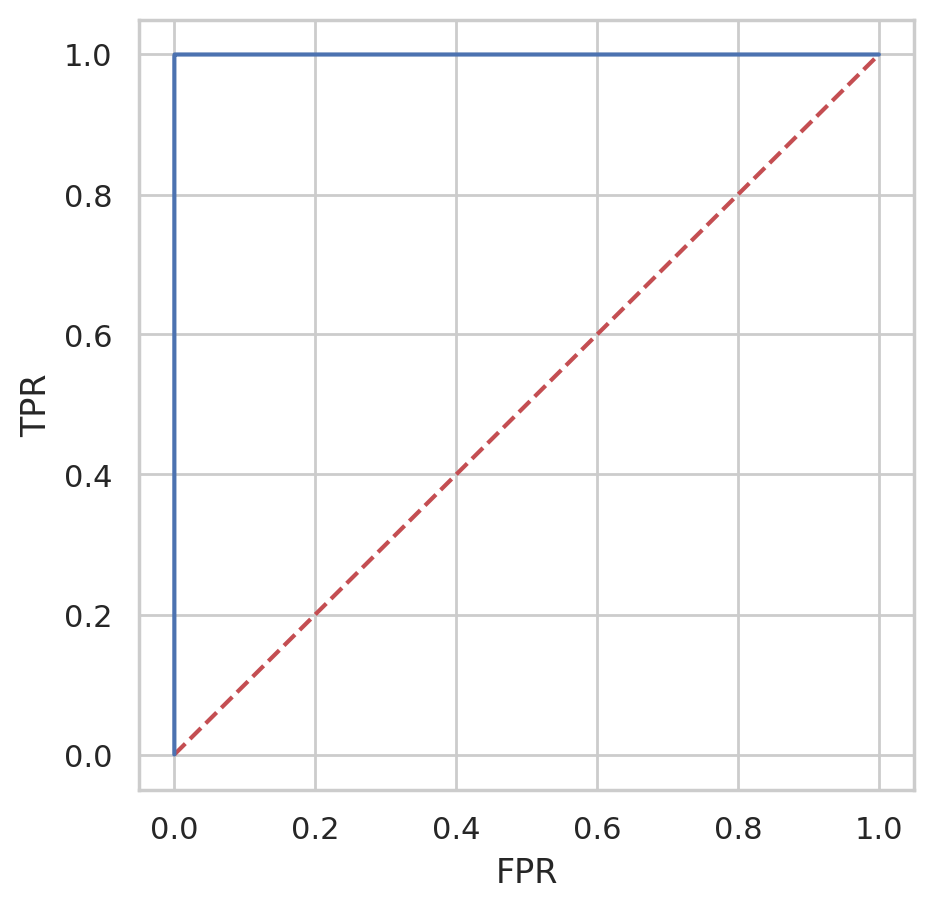

array([[2832,  431],
       [ 533,  238]])

<Figure size 1800x400 with 0 Axes>

Text(0.5, 1.0, 'Logistic Relation Confussion Matrix')

([<matplotlib.axis.XTick at 0x7fe55c566170>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

([<matplotlib.axis.YTick at 0x7fe55c566e30>,
 [Text(0, 0, '0'), Text(0, 1, '1')])

Text(0, 0, '2832')

Text(1004.5000000000002, 0.5, 'True label')

Text(0.5, 7.749107165632944, 'Predicted label')

Text(1, 0, '431')

Text(1087.728670612145, 0.5, 'True label')

Text(0.5, 12.44444444444443, 'Predicted label')

Text(0, 1, '533')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 1, '238')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

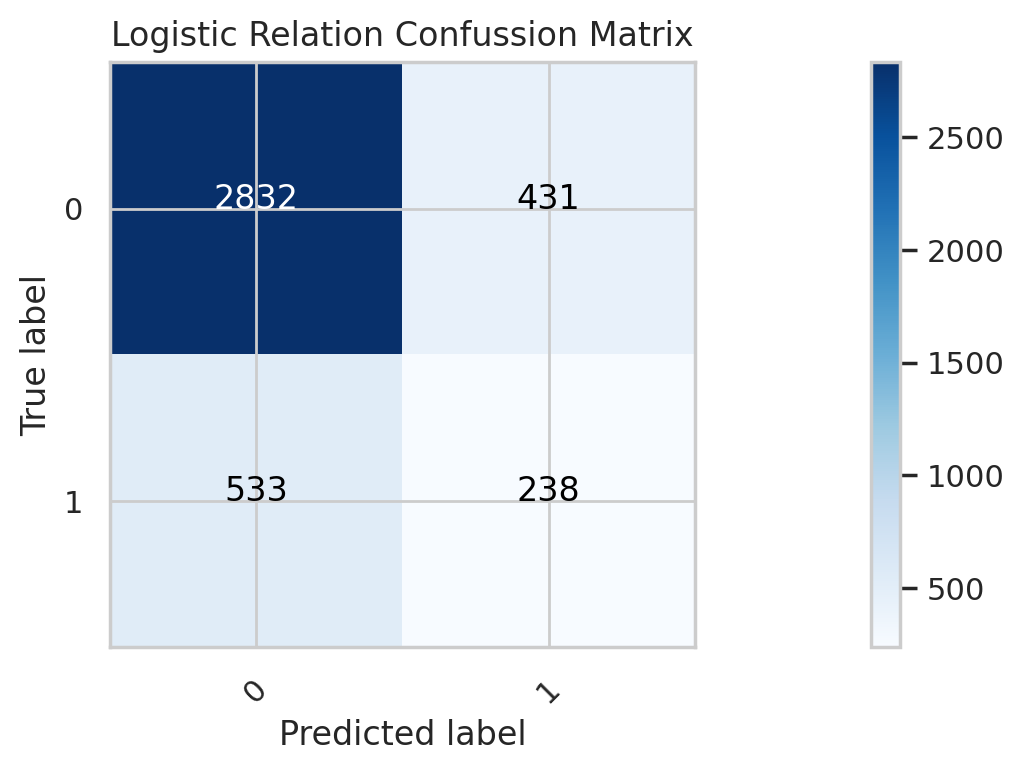

In [9]:
lrModel = logRClassification.stages[2]
trainingSummary = lrModel.summary

trainingSummary.roc.show(5)
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head(5)

## ROC curve Plot

plt.figure(figsize=(5, 5))
plt.plot([0 , 1],[ 0, 1], 'r--')
plt.plot(trainingSummary.roc.select('FPR').collect(), trainingSummary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()


from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = map(str, class_temp)
class_names

cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_temp)
cnf_matrix

plt.figure()
cmap = plt.cm.Blues

plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
plt.title("Logistic Relation Confussion Matrix")
plt.colorbar()
tick_makers = np.arange(len(class_temp))
plt.xticks(tick_makers, class_temp, rotation=45)
plt.yticks(tick_makers, class_temp)
thresh = cnf_matrix.max() /2
#fmt = '.2f'
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, format(cnf_matrix[i, j]),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.show()

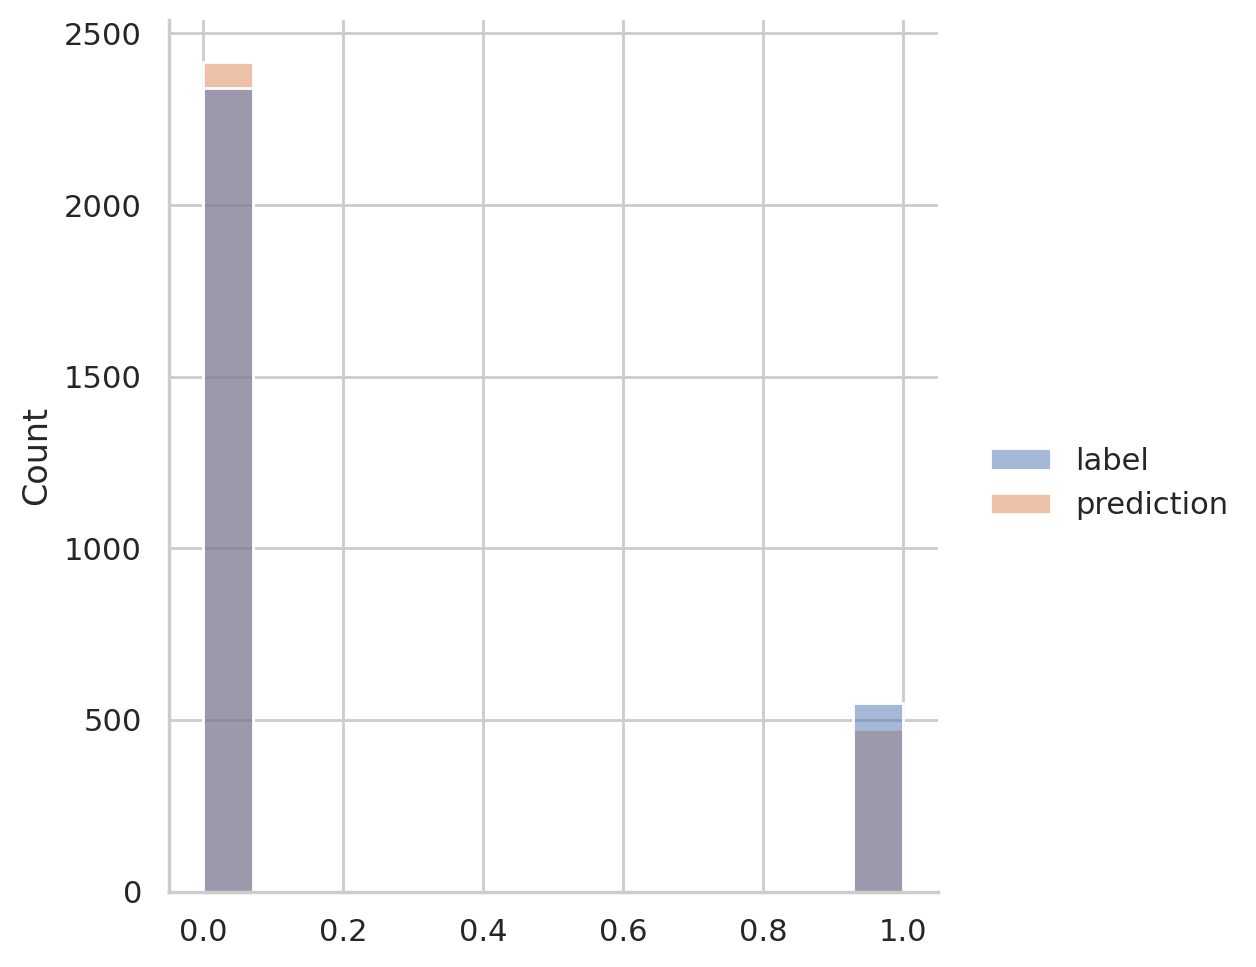

In [10]:
medhv_df = predictions.select(['label', 'prediction']).sample(False, 0.7, 42)
medhv_pandas_df = medhv_df.toPandas()
sns.displot(medhv_pandas_df)

/usr/local/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[Row(long=-122.2300033569336, lat=37.880001068115234, medage=41.0, totrooms=880.0, totbdrms=129.0, pop=322.0, houshlds=126.0, medinc=8.325200080871582, medhv=452600.0),
 Row(long=-122.22000122070312, lat=37.86000061035156, medage=21.0, totrooms=7099.0, totbdrms=1106.0, pop=2401.0, houshlds=1138.0, medinc=8.301400184631348, medhv=358500.0),
 Row(long=-122.23999786376953, lat=37.849998474121094, medage=52.0, totrooms=1467.0, totbdrms=190.0, pop=496.0, houshlds=177.0, medinc=7.257400035858154, medhv=352100.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1274.0, totbdrms=235.0, pop=558.0, houshlds=219.0, medinc=5.643099784851074, medhv=341300.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1627.0, totbdrms=280.0, pop=565.0, houshlds=259.0, medinc=3.8461999893188477, medhv=342200.0)]

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20640.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631| 537.898|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.2479|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+

+-----+------+--------+------+--------+------+--------+--------+----------+----------------+-----------+----------------+--------------+----------------+----------------+------------------+--------------+------------------------+-------------------+------------------------+----------------------+------------------

['features', 'medhv']

+--------------------+-----+--------------+
|            features|medhv|predictedLabel|
+--------------------+-----+--------------+
|(22226,[0,1945,60...|    0|             0|
|(22226,[0,1952,59...|    0|             0|
|(22226,[0,1965,59...|    1|             0|
|(22226,[0,1965,59...|    0|             0|
|(22226,[0,1990,59...|    1|             0|
|(22226,[0,2110,58...|    0|             0|
|(22226,[0,2111,58...|    0|             0|
|(22226,[0,2220,59...|    0|             0|
|(22226,[0,2432,58...|    0|             0|
|(22226,[0,2673,59...|    1|             0|
|(22226,[0,2854,60...|    0|             0|
|(22226,[0,2863,58...|    0|             0|
|(22226,[0,3325,62...|    0|             1|
|(22226,[1,1979,58...|    1|             1|
|(22226,[1,1979,60...|    0|             0|
|(22226,[1,2018,58...|    0|             0|
|(22226,[1,2233,59...|    0|             0|
|(22226,[1,2389,60...|    0|             0|
|(22226,[1,2428,58...|    1|             0|
|(22226,[1,2643,58...|    0|    

<Figure size 500x500 with 0 Axes>

Text(0.5, 0, 'FPR')

Text(0, 0.5, 'TPR')

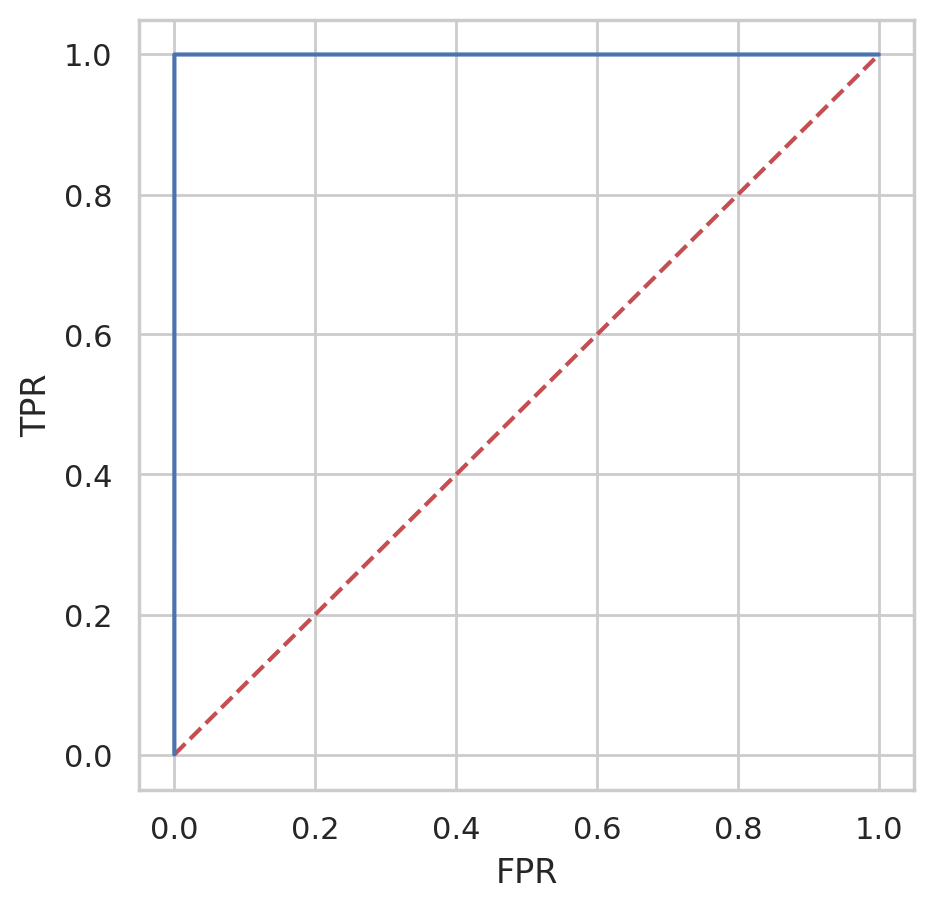

array([[2972,  428],
       [ 480,  279]])

<Figure size 1800x400 with 0 Axes>

Text(0.5, 1.0, 'Logistic Relation Confussion Matrix')

([<matplotlib.axis.XTick at 0x7fe557e14fd0>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

([<matplotlib.axis.YTick at 0x7fe557e15780>,
 [Text(0, 0, '0'), Text(0, 1, '1')])

Text(0, 0, '2972')

Text(1004.5000000000002, 0.5, 'True label')

Text(0.5, 7.749107165632944, 'Predicted label')

Text(1, 0, '428')

Text(1087.728670612145, 0.5, 'True label')

Text(0.5, 12.44444444444443, 'Predicted label')

Text(0, 1, '480')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 1, '279')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

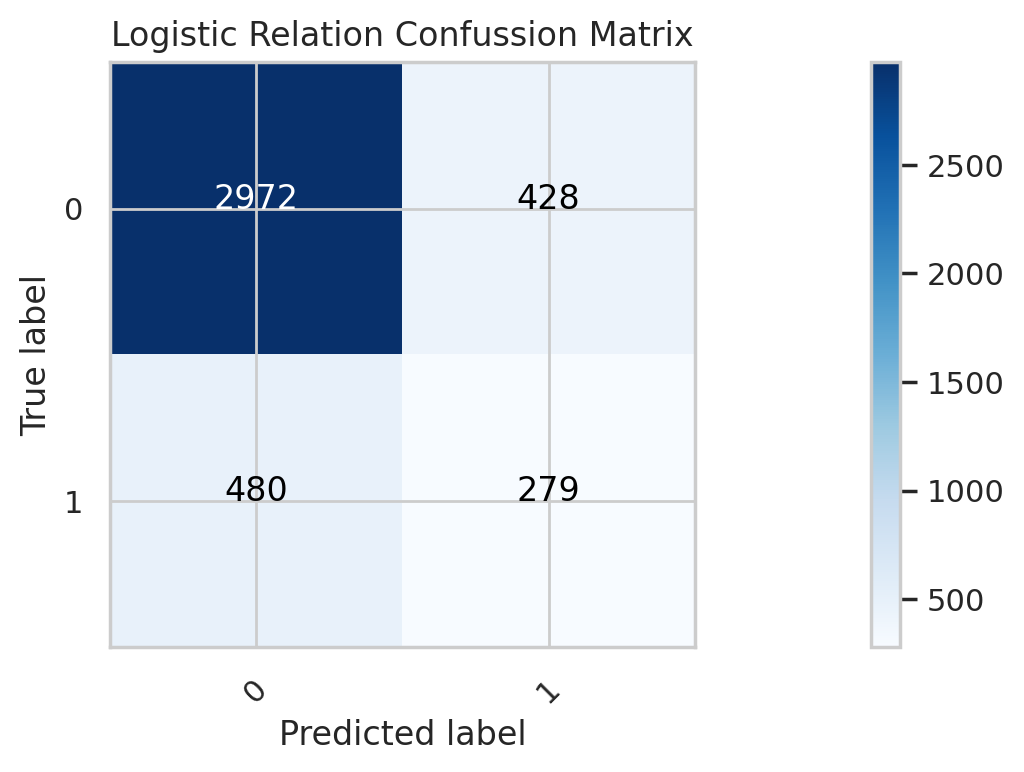

In [11]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, VectorIndexer, IndexToString
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

# Spark Session Creation

ss = SparkSession.builder.master("local[4]").appName("Logistic-Regression").getOrCreate()
sc = ss.sparkContext
sqlContext = SQLContext(sc)

# Load data from file into dataframe
HOUSING_DATA = 'input/cal_housing.data'
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)
# Load housing data
housing_df = ss.read.csv(path=HOUSING_DATA, schema=schema).cache()

# Inspect first five rows
housing_df.take(5)

# show the dataframe columns
housing_df.columns

# Summary of the data

(housing_df.describe().select(
                    "summary",
                    F.round("medage", 4).alias("medage"),
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv"))
                    .show())


# Adjust the values of `medianHouseValue`
housing_df = housing_df.withColumn("medhv", col("medhv")/100000)


# Add the new columns to `df`
housing_df = (housing_df.withColumn("rmsperhh", F.round(col("totrooms")/col("houshlds"), 2))
                       .withColumn("popperhh", F.round(col("pop")/col("houshlds"), 2))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms")/col("totrooms"), 2)))

# Re-order and select columns
housing_df = housing_df.select("medhv", 
                               "medage",
                              "totbdrms", 
                              "pop", 
                              "houshlds", 
                              "medinc", 
                              "rmsperhh", 
                              "popperhh", 
                              "bdrmsperrm")


#### Unsupervised way of Bionomial Learning

## Feature group normalization

housing_df = housing_df.withColumn("medhv", F.when((col("medhv") <=3.0), 0).when((col("medhv") > 3.0),1))

#### Feature Extraction

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler


featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage"]

## Indexing creation for the featureCols .. This indexing gives us a mapping. 
indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in featureCols]

# encoder creation
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers]

# Use a VectorAssembler to put features into a feature vector column:



# put features into a feature vector column
assembler = VectorAssembler(inputCols= [encoder.getOutputCol() for encoder in encoders], outputCol="features")
pipeline = Pipeline(stages=indexers + encoders + [assembler])
assembled_df= pipeline.fit(housing_df).transform(housing_df)

# The following line works for supervised learning, where the label is provided by the user. For Unsupervised Learning the label is detected by the learning mechanism
#assembled_df = assembled_df.withColumn('label', col('medhv'))

assembled_df.show(5, truncate=False)

from pyspark.ml.classification import LogisticRegression

finalized_df = assembled_df.select("features", "medhv")
finalized_df.show(n=10)

# Index labels, adding metadata to the label column

labelIndexer = StringIndexer(inputCol='medhv', outputCol='indexedLabel').fit(finalized_df)
labelIndexer.transform(finalized_df).show(5, True)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(finalized_df)
featureIndexer.transform(finalized_df).show(5, True)

## Building the ML model

# Split the data into train and test sets
train_data, test_data = finalized_df.randomSplit([.8,.2])
train_data.columns

logr = LogisticRegression(featuresCol="indexedFeatures", labelCol='indexedLabel')

labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr, labelConverter])

logRClassification = pipeline.fit(train_data)

## Generate Predictions
predictions = logRClassification.transform(test_data)
preandLables = predictions.select("features", "medhv", "predictedLabel").show()

evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1 - accuracy))

lrModel = logRClassification.stages[2]
trainingSummary = lrModel.summary

trainingSummary.roc.show(5)
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head(5)

## ROC curve Plot

plt.figure(figsize=(5, 5))
plt.plot([0 , 1],[ 0, 1], 'r--')
plt.plot(trainingSummary.roc.select('FPR').collect(), trainingSummary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()


from sklearn.metrics import confusion_matrix
y_true = predictions.select("medhv")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

class_temp = predictions.select("medhv").groupBy("medhv")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["medhv"].values.tolist()
class_names = map(str, class_temp)
class_names

cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_temp)
cnf_matrix

plt.figure()
cmap = plt.cm.Blues

plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
plt.title("Logistic Relation Confussion Matrix")
plt.colorbar()
tick_makers = np.arange(len(class_temp))
plt.xticks(tick_makers, class_temp, rotation=45)
plt.yticks(tick_makers, class_temp)
thresh = cnf_matrix.max() /2
#fmt = '.2f'
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, format(cnf_matrix[i, j]),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.show()


## Exercise 1

Can we redo the whole process of our highly used Movie Ratings dataset? Can we classify the movies based on their ratings?
Select which features we can use for logistic regression classification. Explain why did you choose them.

+-------+------------------+
|movieId|         avgRating|
+-------+------------------+
|   1580| 3.487878787878788|
|   2366|              3.64|
|   3175|              3.58|
|   1088| 3.369047619047619|
|  32460|              4.25|
|  44022| 3.217391304347826|
|  96488|              4.25|
|   1238| 4.055555555555555|
|   1342|               2.5|
|   1591|2.6346153846153846|
|   1645| 3.411764705882353|
|   4519|3.3333333333333335|
|   2142|               2.7|
|    471|              3.55|
|   3997|1.8333333333333333|
|    833|               2.0|
|   3918|3.2777777777777777|
|   7982|              3.25|
|   1959|3.6666666666666665|
|  68135|              3.55|
+-------+------------------+
only showing top 20 rows

+-------+---------+---------------+-----------------+-----------------------+-------------------------+----------------------------+
|movieId|avgRating|movieId_indexed|avgRating_indexed|movieId_indexed_encoded|avgRating_indexed_encoded|features                    |
+-------+---

['features', 'avgRating']

+--------------------------+---------+--------------+
|features                  |avgRating|predictedLabel|
+--------------------------+---------+--------------+
|(9724,[0,9723],[1.0,1.0]) |0        |0             |
|(9724,[1,9723],[1.0,1.0]) |0        |0             |
|(9724,[3,9723],[1.0,1.0]) |0        |0             |
|(9724,[10,9723],[1.0,1.0])|0        |0             |
|(9724,[11,9723],[1.0,1.0])|0        |0             |
|(9724,[13,9723],[1.0,1.0])|0        |0             |
|(9724,[16,9723],[1.0,1.0])|0        |0             |
|(9724,[17,9723],[1.0,1.0])|0        |0             |
|(9724,[22,9723],[1.0,1.0])|0        |0             |
|(9724,[23,9723],[1.0,1.0])|0        |0             |
|(9724,[29,9723],[1.0,1.0])|0        |0             |
|(9724,[30,9723],[1.0,1.0])|0        |0             |
|(9724,[31,9723],[1.0,1.0])|0        |0             |
|(9724,[32,9723],[1.0,1.0])|0        |0             |
|(9724,[39],[1.0])         |1        |1             |
|(9724,[40,9723],[1.0,1.0])|

<Figure size 500x500 with 0 Axes>

Text(0.5, 0, 'FPR')

Text(0, 0.5, 'TPR')

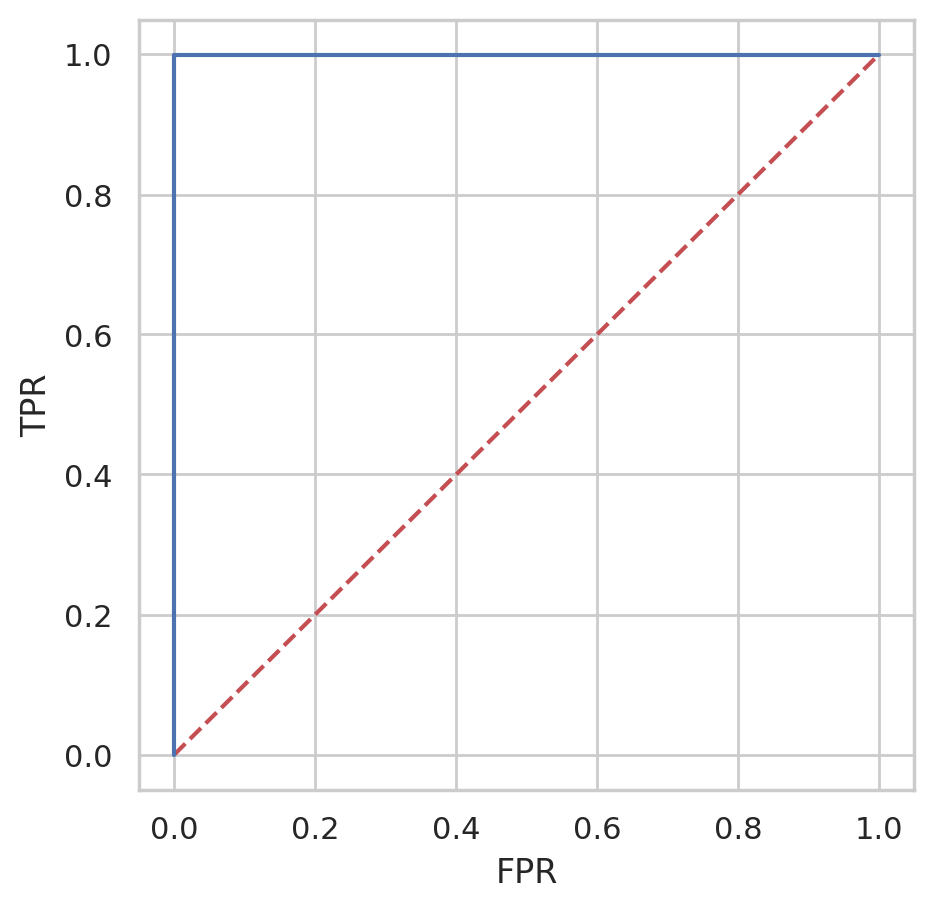

array([[1689,    0],
       [   0,  237]])

<Figure size 1800x400 with 0 Axes>

Text(0.5, 1.0, 'Logistic Relation Confussion Matrix')

([<matplotlib.axis.XTick at 0x7fe54345d720>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

([<matplotlib.axis.YTick at 0x7fe54345e2c0>,
 [Text(0, 0, '0'), Text(0, 1, '1')])

Text(0, 0, '1689')

Text(1004.5000000000002, 0.5, 'True label')

Text(0.5, 7.749107165632944, 'Predicted label')

Text(1, 0, '0')

Text(1087.728670612145, 0.5, 'True label')

Text(0.5, 12.44444444444443, 'Predicted label')

Text(0, 1, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 1, '237')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

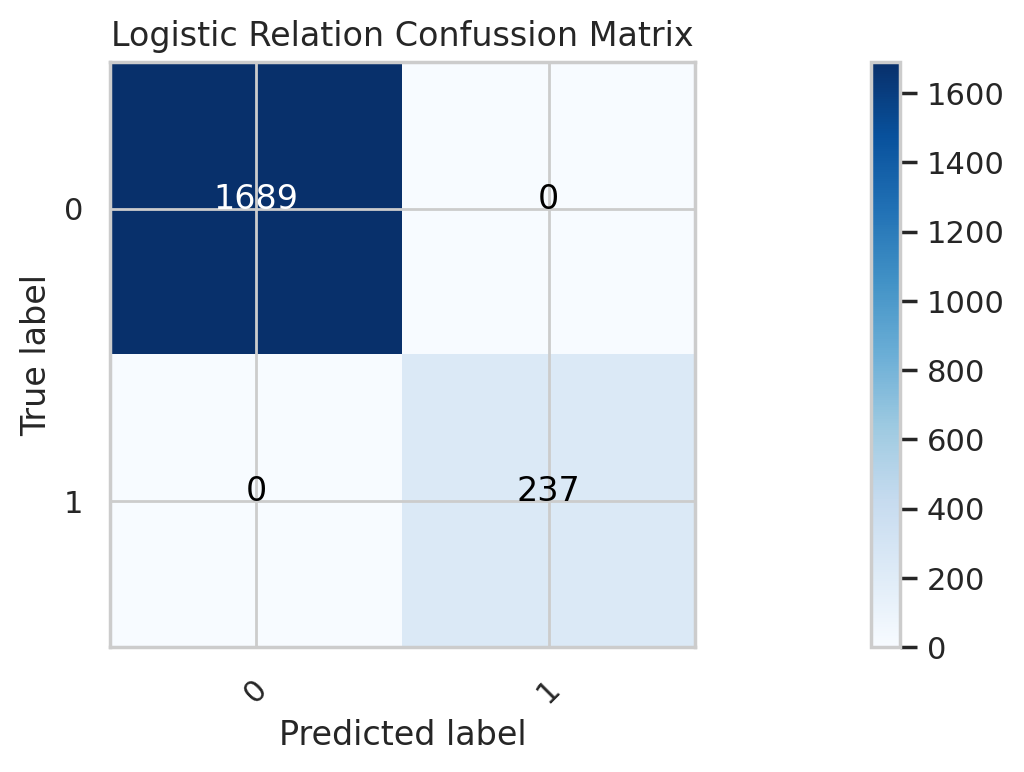

In [124]:

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from sklearn.metrics import confusion_matrix
MOVIES_PATH = './Movies/movies.csv'
RATINGS_PATH = './Movies/ratings.csv'
moviesDF = ss.read.csv(MOVIES_PATH, header=True, inferSchema=True)
ratingsDF = ss.read.csv(RATINGS_PATH, header=True, inferSchema=True)

joinedDF = moviesDF.join(ratingsDF, 'movieId').groupBy("movieId").agg(F.avg(col("rating")).alias("avgRating"))
joinedDF.show()

joinedDF = joinedDF.withColumn("avgRating", F.when((col("avgRating") <= 4), 0).otherwise(1))

featureCols = ["movieId","avgRating"]

indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in featureCols]
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers]

assembler = VectorAssembler(inputCols= [encoder.getOutputCol() for encoder in encoders], outputCol="features")
pipeline = Pipeline(stages=indexers + encoders + [assembler])
assembled_df= pipeline.fit(joinedDF).transform(joinedDF)

assembled_df.show(5, truncate=False)


finalized_df = assembled_df.select("features", "avgRating")
finalized_df.show(n=10)


labelIndexer = StringIndexer(inputCol='avgRating', outputCol='indexedLabel').fit(finalized_df)
labelIndexer.transform(finalized_df).show(5, False)


featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(finalized_df)
featureIndexer.transform(finalized_df).show(5, False)

train_data, test_data = finalized_df.randomSplit([.8,.2])
train_data.columns

logr = LogisticRegression(featuresCol="indexedFeatures", labelCol='indexedLabel')

labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr, labelConverter])

logRClassification = pipeline.fit(train_data)
predictions = logRClassification.transform(test_data)
preandLables = predictions.select("features", "avgRating", "predictedLabel").show(truncate=False)

evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1 - accuracy))

lrModel = logRClassification.stages[2]
trainingSummary = lrModel.summary

trainingSummary.roc.show(5)
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head(5)


plt.figure(figsize=(5, 5))
plt.plot([0 , 1],[ 0, 1], 'r--')
plt.plot(trainingSummary.roc.select('FPR').collect(), trainingSummary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()


y_true = predictions.select("avgRating")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

class_temp = predictions.select("avgRating").groupBy("avgRating")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["avgRating"].values.tolist()
class_names = map(str, class_temp)
class_names

cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_temp)
cnf_matrix

plt.figure()
cmap = plt.cm.Blues

plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
plt.title("Logistic Relation Confussion Matrix")
plt.colorbar()
tick_makers = np.arange(len(class_temp))
plt.xticks(tick_makers, class_temp, rotation=45)
plt.yticks(tick_makers, class_temp)
thresh = cnf_matrix.max() /2
#fmt = '.2f'
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, format(cnf_matrix[i, j]),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.show()

I used movieId and avgRating to carry out the logistic regression, as I chose to calculate the average rating in the DataFrame. I've decided to group the DataFrame by movieId since it will result in much better results for the average.

### Multinomial Logistic Regression
Multiclass classification is supported via multinomial logistic (softmax) regression. In multinomial logistic regression, the algorithm produces K
 sets of coefficients, or a matrix of dimension K×J
 where K
 is the number of outcome classes and J
 is the number of features. If the algorithm is fit with an intercept term then a length K
 vector of intercepts is available.

Multinomial coefficients are available as coefficientMatrix and intercepts are available as interceptVector.

coefficients and intercept methods on a logistic regression model trained with multinomial family are not supported. Use coefficientMatrix and interceptVector instead.

The conditional probabilities of the outcome classes k∈1,2,…,K  are modeled using the softmax function.

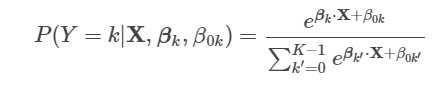

We minimize the weighted negative log-likelihood, using a multinomial response model, with elastic-net penalty to control for overfitting.
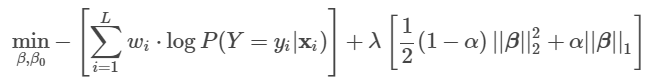

In other words, in statistics, multinomial logistic regression is a classification method that generalizes logistic regression to multiclass problems, i.e. with more than two possible discrete outcomes.[1] That is, it is a model that is used to predict the probabilities of the different possible outcomes of a categorically distributed dependent variable, given a set of independent variables (which may be real-valued, binary-valued, categorical-valued, etc.).

#### Step 1: SparkSession Creation


In [13]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, VectorIndexer, IndexToString, StringIndexer, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

# Spark Session Creation

ss = SparkSession.builder.master("local[4]").appName("Multinomial-Logistic-Regression").getOrCreate()
sc = ss.sparkContext
sqlContext = SQLContext(sc)


/usr/local/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


#### Step 2: data Loading and data Preprocessing

In [14]:
# Load data from file into dataframe
HOUSING_DATA = 'input/cal_housing.data'
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)
# Load housing data
housing_df = ss.read.csv(path=HOUSING_DATA, schema=schema).cache()

# Inspect first five rows
housing_df.take(5)

# show the dataframe columns
housing_df.columns

# Summary of the data

(housing_df.describe().select(
                    "summary",
                    F.round("medage", 4).alias("medage"),
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv"))
                    .show())


# Adjust the values of `medianHouseValue`
housing_df = housing_df.withColumn("medhv", col("medhv")/100000)


# Add the new columns to `df`
housing_df = (housing_df.withColumn("rmsperhh", F.round(col("totrooms")/col("houshlds"), 2))
                       .withColumn("popperhh", F.round(col("pop")/col("houshlds"), 2))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms")/col("totrooms"), 2)))

# Re-order and select columns
housing_df = housing_df.select("medhv", 
                               "medage",
                              "totbdrms", 
                              "pop", 
                              "houshlds", 
                              "medinc", 
                              "rmsperhh", 
                              "popperhh", 
                              "bdrmsperrm")
## Feature group normalization
'''In Multinomial Regression classification, more than two classes can be classified. So, we need to create more classes/label data '''
housing_df = housing_df.withColumn("medhvRounded", 
                                   F.when((col("medhv") <=1), 0)
                                   .when((col("medhv") <= 2) & (col("medhv") > 1),1)
                                   .when((col("medhv") <= 3) & (col("medhv") > 2),2)
                                   .when((col("medhv") <= 4) & (col("medhv") > 3),3)
                                   .when((col("medhv") > 4),4))
housing_df.show(5)

[Row(long=-122.2300033569336, lat=37.880001068115234, medage=41.0, totrooms=880.0, totbdrms=129.0, pop=322.0, houshlds=126.0, medinc=8.325200080871582, medhv=452600.0),
 Row(long=-122.22000122070312, lat=37.86000061035156, medage=21.0, totrooms=7099.0, totbdrms=1106.0, pop=2401.0, houshlds=1138.0, medinc=8.301400184631348, medhv=358500.0),
 Row(long=-122.23999786376953, lat=37.849998474121094, medage=52.0, totrooms=1467.0, totbdrms=190.0, pop=496.0, houshlds=177.0, medinc=7.257400035858154, medhv=352100.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1274.0, totbdrms=235.0, pop=558.0, houshlds=219.0, medinc=5.643099784851074, medhv=341300.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1627.0, totbdrms=280.0, pop=565.0, houshlds=259.0, medinc=3.8461999893188477, medhv=342200.0)]

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20640.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631| 537.898|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.2479|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+



'In Multinomial Regression classification, more than two classes can be classified. So, we need to create more classes/label data '

+-----+------+--------+------+--------+------+--------+--------+----------+------------+
|medhv|medage|totbdrms|   pop|houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|medhvRounded|
+-----+------+--------+------+--------+------+--------+--------+----------+------------+
|4.526|  41.0|   129.0| 322.0|   126.0|8.3252|    6.98|    2.56|      0.15|           4|
|3.585|  21.0|  1106.0|2401.0|  1138.0|8.3014|    6.24|    2.11|      0.16|           3|
|3.521|  52.0|   190.0| 496.0|   177.0|7.2574|    8.29|     2.8|      0.13|           3|
|3.413|  52.0|   235.0| 558.0|   219.0|5.6431|    5.82|    2.55|      0.18|           3|
|3.422|  52.0|   280.0| 565.0|   259.0|3.8462|    6.28|    2.18|      0.17|           3|
+-----+------+--------+------+--------+------+--------+--------+----------+------------+
only showing top 5 rows



#### Step 3: Feature Selection and Multinomial Regression Classifier Model Creation

In [15]:
featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage"]

## Indexing creation for the featureCols .. This indexing gives us a mapping. 
indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in featureCols]

# encoder creation
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers]

# Use a VectorAssembler to put features into a feature vector column:
# put features into a feature vector column
assembler = VectorAssembler(inputCols= [encoder.getOutputCol() for encoder in encoders], outputCol="features")
pipeline = Pipeline(stages=indexers + encoders + [assembler])
assembled_df= pipeline.fit(housing_df).transform(housing_df)
assembled_df = assembled_df.withColumn('label', col('medhvRounded'))
assembled_df.show(5, truncate=False)

finalized_df = assembled_df.select("features", "label")
finalized_df.show(n=5)

quality_udf = udf(lambda x: x, StringType())
housing_df = housing_df.withColumn("label", quality_udf("medhvRounded"))

# Re-order and select columns
housing_df = housing_df.select("totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage", "label")


# We need to transform the dataset to Dataframe so that each class can be seperated perfectly.
transformed_df = housing_df.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])
transformed_df.show(5, truncate=False)


+-----+------+--------+------+--------+------+--------+--------+----------+------------+----------------+-----------+----------------+--------------+----------------+----------------+------------------+--------------+------------------------+-------------------+------------------------+----------------------+------------------------+------------------------+--------------------------+----------------------+----------------------------------------------------------------------------------------+-----+
|medhv|medage|totbdrms|pop   |houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|medhvRounded|totbdrms_indexed|pop_indexed|houshlds_indexed|medinc_indexed|rmsperhh_indexed|popperhh_indexed|bdrmsperrm_indexed|medage_indexed|totbdrms_indexed_encoded|pop_indexed_encoded|houshlds_indexed_encoded|medinc_indexed_encoded|rmsperhh_indexed_encoded|popperhh_indexed_encoded|bdrmsperrm_indexed_encoded|medage_indexed_encoded|features                                                                            

#### Step 4: Feature Index creation for better mapping

In [16]:
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(transformed_df)
labelIndexer.transform(transformed_df).show(5, True)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=6).fit(transformed_df)
featureIndexer.transform(transformed_df).show(5, True)


+--------------------+-----+------------+
|            features|label|indexedLabel|
+--------------------+-----+------------+
|[129.0,322.0,126....|    4|         4.0|
|[1106.0,2401.0,11...|    3|         3.0|
|[190.0,496.0,177....|    3|         3.0|
|[235.0,558.0,219....|    3|         3.0|
|[280.0,565.0,259....|    3|         3.0|
+--------------------+-----+------------+
only showing top 5 rows

+--------------------+-----+--------------------+
|            features|label|     indexedFeatures|
+--------------------+-----+--------------------+
|[129.0,322.0,126....|    4|[129.0,322.0,126....|
|[1106.0,2401.0,11...|    3|[1106.0,2401.0,11...|
|[190.0,496.0,177....|    3|[190.0,496.0,177....|
|[235.0,558.0,219....|    3|[235.0,558.0,219....|
|[280.0,565.0,259....|    3|[280.0,565.0,259....|
+--------------------+-----+--------------------+
only showing top 5 rows



#### Step 5: Training and Testing Data Creation

In [17]:
# Split the data into training and test sets (30% held out for testing)

(train_Data, test_Data) = transformed_df.randomSplit([0.7, 0.3], seed=1234)

train_Data.show(5,False)
test_Data.show(5,False)

+---------------------------------------------------+-----+
|features                                           |label|
+---------------------------------------------------+-----+
|[2.0,8.0,2.0,1.625,3.0,4.0,0.33,1.0]               |0    |
|[3.0,5.0,3.0,0.5360000133514404,6.0,1.67,0.17,26.0]|2    |
|[3.0,11.0,3.0,5.047999858856201,5.0,3.67,0.2,26.0] |3    |
|[3.0,29.0,9.0,8.0,2.89,3.22,0.12,28.0]             |2    |
|[3.0,49.0,8.0,4.625,3.75,6.13,0.1,16.0]            |2    |
+---------------------------------------------------+-----+
only showing top 5 rows

+----------------------------------------------------+-----+
|features                                            |label|
+----------------------------------------------------+-----+
|[1.0,13.0,1.0,15.000100135803223,8.0,13.0,0.13,52.0]|4    |
|[2.0,6.0,2.0,2.375,1.0,3.0,1.0,4.0]                 |1    |
|[3.0,8.0,6.0,1.625,3.0,1.33,0.17,4.0]               |2    |
|[6.0,3.0,4.0,0.5360000133514404,4.5,0.75,0.33,16.0] |3    |
|[6.0,41

#### Step 6: Train the Model. Fit the MultiNomial Classifier

In [18]:
logr = LogisticRegression(featuresCol='indexedFeatures', labelCol='indexedLabel')

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr,labelConverter])

# Train model.  This also runs the indexers.
logRClassification = pipeline.fit(train_Data)

#### Step 7: Generate Predictions from the trained Model

In [19]:
predictions = logRClassification.transform(test_Data)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)


+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|[1.0,13.0,1.0,15....|    4|             4|
|[2.0,6.0,2.0,2.37...|    1|             4|
|[3.0,8.0,6.0,1.62...|    2|             0|
|[6.0,3.0,4.0,0.53...|    3|             0|
|[6.0,41.0,10.0,10...|    1|             4|
+--------------------+-----+--------------+
only showing top 5 rows



#### Step 8: Evaluation

Test Error = 0.421546


'\nlrModel = logRClassification.stages[2]\ntrainingSummary = lrModel.summary\n\n#trainingSummary.roc.show(5)\n#print("areaUnderROC: " + str(trainingSummary.areaUnderROC))\n\nfMeasure = trainingSummary.fMeasureByLabel\nmaxFMeasure = fMeasure.groupBy().max(\'F-Measure\').select(\'max(F-Measure)\').head(5)\n\n\n## ROC curve Plot\n\nplt.figure(figsize=(5, 5))\nplt.plot([0 , 1],[ 0, 1], \'r--\')\nplt.plot(trainingSummary.roc.select(\'FPR\').collect(), trainingSummary.roc.select(\'TPR\').collect())\nplt.xlabel(\'FPR\')\nplt.ylabel(\'TPR\')\nplt.show()\n'

['1', '2', '0', '3', '4']

array([[1821,  334,  255,   10,   12],
       [ 585,  795,   26,   34,   45],
       [ 516,   14,  571,    0,    2],
       [  94,  380,    4,   74,  100],
       [  31,  105,    7,   52,  315]])

<Figure size 1800x400 with 0 Axes>

Text(0.5, 1.0, 'Multinomial Logistic Relation Confussion Matrix')

([<matplotlib.axis.XTick at 0x7fe55c2eab00>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '0'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

([<matplotlib.axis.YTick at 0x7fe55deb9900>,
 [Text(0, 0, '1'),
  Text(0, 1, '2'),
  Text(0, 2, '0'),
  Text(0, 3, '3'),
  Text(0, 4, '4')])

Text(0, 0, '1821')

Text(1004.5000000000002, 0.5, 'True label')

Text(0.5, 7.749107165632944, 'Predicted label')

Text(1, 0, '334')

Text(1087.728670612145, 0.5, 'True label')

Text(0.5, 12.44444444444443, 'Predicted label')

Text(2, 0, '255')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 0, '10')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 0, '12')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 1, '585')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 1, '795')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 1, '26')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 1, '34')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 1, '45')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 2, '516')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 2, '14')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 2, '571')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 2, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 2, '2')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 3, '94')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 3, '380')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 3, '4')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 3, '74')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 3, '100')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 4, '31')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 4, '105')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 4, '7')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 4, '52')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 4, '315')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

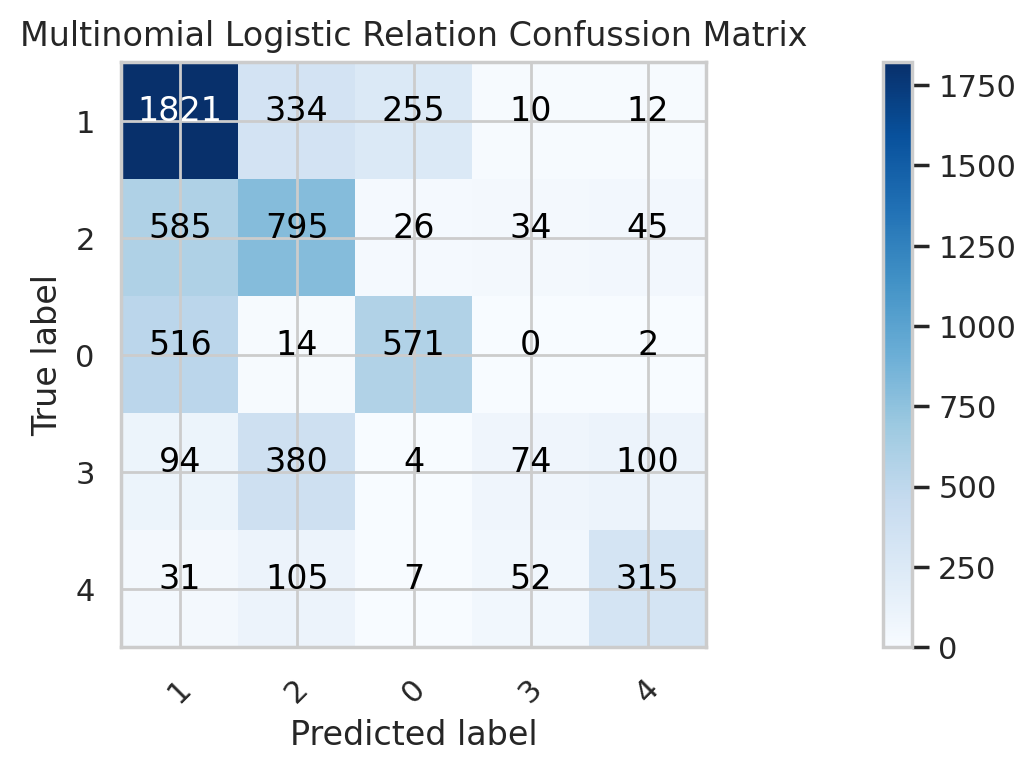

In [20]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

'''
lrModel = logRClassification.stages[2]
trainingSummary = lrModel.summary

#trainingSummary.roc.show(5)
#print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

fMeasure = trainingSummary.fMeasureByLabel
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head(5)


## ROC curve Plot

plt.figure(figsize=(5, 5))
plt.plot([0 , 1],[ 0, 1], 'r--')
plt.plot(trainingSummary.roc.select('FPR').collect(), trainingSummary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
'''

from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = []
for i in range(0, len(class_temp)):
    class_names.append(str(class_temp[i]))
class_names

cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
cnf_matrix

plt.figure()
cmap = plt.cm.Blues

plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
plt.title("Multinomial Logistic Relation Confussion Matrix")
plt.colorbar()
tick_makers = np.arange(len(class_temp))
plt.xticks(tick_makers, class_temp, rotation=45)
plt.yticks(tick_makers, class_temp)
thresh = cnf_matrix.max() /2
#fmt = '.2f'
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, format(cnf_matrix[i, j]),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.show()


## Exercise 2

Can we redo the whole process of our highly used Movie Ratings dataset? Can we classify the movies based on their ratings in 5 different classes?
Select which features we can use for logistic regression classification. Explain why did you choose them.

In [151]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import RegressionMetrics
ratingsDF = ss.read.csv("Movies/ratings.csv", header=True, inferSchema=True)

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, VectorIndexer, IndexToString, StringIndexer, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

# Spark Session Creation

ss = SparkSession.builder.master("local[4]").appName("Multinomial-Logistic-Regression").getOrCreate()
sc = ss.sparkContext
sqlContext = SQLContext(sc)


/usr/local/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [152]:
moviesDF = ss.read.csv("Movies/movies.csv", header=True, inferSchema=True).cache()
ratingsDF = ss.read.csv("Movies/ratings.csv", header=True, inferSchema=True).cache()

joinedDF = moviesDF.join(ratingsDF, "movieId")

# Inspect first five rows
joinedDF.take(5)

# show the dataframe columns
joinedDF.columns

# Summary of the data

(joinedDF.describe().select(
                    "summary",
                    F.round("rating", 4).alias("rating"))
                    .show())

joinedDF = joinedDF.withColumn("ratingRounded", 
                                   F.when((col("rating") <= 1), 1)
                                   .when((col("rating") <= 2) & (col("rating") > 1), 2)
                                   .when((col("rating") <= 3) & (col("rating") > 2), 3)
                                   .when((col("rating") <= 4) & (col("rating") > 3), 4)
                                   .when((col("rating") > 4), 5))
joinedDF.show(5, truncate=False)

[Row(movieId=1, title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy', userId=1, rating=4.0, timestamp=964982703),
 Row(movieId=3, title='Grumpier Old Men (1995)', genres='Comedy|Romance', userId=1, rating=4.0, timestamp=964981247),
 Row(movieId=6, title='Heat (1995)', genres='Action|Crime|Thriller', userId=1, rating=4.0, timestamp=964982224),
 Row(movieId=47, title='Seven (a.k.a. Se7en) (1995)', genres='Mystery|Thriller', userId=1, rating=5.0, timestamp=964983815),
 Row(movieId=50, title='Usual Suspects, The (1995)', genres='Crime|Mystery|Thriller', userId=1, rating=5.0, timestamp=964982931)]

['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp']

+-------+--------+
|summary|  rating|
+-------+--------+
|  count|100836.0|
|   mean|  3.5016|
| stddev|  1.0425|
|    min|     0.5|
|    max|     5.0|
+-------+--------+

+-------+---------------------------+-------------------------------------------+------+------+---------+-------------+
|movieId|title                      |genres                                     |userId|rating|timestamp|ratingRounded|
+-------+---------------------------+-------------------------------------------+------+------+---------+-------------+
|1      |Toy Story (1995)           |Adventure|Animation|Children|Comedy|Fantasy|1     |4.0   |964982703|4            |
|3      |Grumpier Old Men (1995)    |Comedy|Romance                             |1     |4.0   |964981247|4            |
|6      |Heat (1995)                |Action|Crime|Thriller                      |1     |4.0   |964982224|4            |
|47     |Seven (a.k.a. Se7en) (1995)|Mystery|Thriller                           |1     |5.0   |964983815|5  

In [153]:
featureCols = ["movieId", "rating"]

indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in featureCols]
# encoder creation
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers]

# Use a VectorAssembler to put features into a feature vector column:
# put features into a feature vector column
assembler = VectorAssembler(inputCols= [encoder.getOutputCol() for encoder in encoders], outputCol="features")
pipeline = Pipeline(stages=indexers + encoders + [assembler])
joinedDF= pipeline.fit(joinedDF).transform(joinedDF)
joinedDF = joinedDF.withColumn('label', col('ratingRounded'))
joinedDF.show(5, truncate=False)

finalized_df = joinedDF.select("features", "label")
finalized_df.show(n=5)


+-------+---------------------------+-------------------------------------------+------+------+---------+-------------+---------------+--------------+-----------------------+----------------------+---------------------------+-----+
|movieId|title                      |genres                                     |userId|rating|timestamp|ratingRounded|movieId_indexed|rating_indexed|movieId_indexed_encoded|rating_indexed_encoded|features                   |label|
+-------+---------------------------+-------------------------------------------+------+------+---------+-------------+---------------+--------------+-----------------------+----------------------+---------------------------+-----+
|1      |Toy Story (1995)           |Adventure|Animation|Children|Comedy|Fantasy|1     |4.0   |964982703|4            |11.0           |0.0           |(9723,[11],[1.0])      |(9,[0],[1.0])         |(9732,[11,9723],[1.0,1.0]) |4    |
|3      |Grumpier Old Men (1995)    |Comedy|Romance                     

In [154]:
quality_udf = udf(lambda x: x, StringType())
joinedDF = joinedDF.withColumn("label", quality_udf("ratingRounded"))

# Re-order and select columns
joinedDF = joinedDF.select("movieId", "rating", "label")
joinedDF.show()

# We need to transform the dataset to Dataframe so that each class can be seperated perfectly.
joinedDF = joinedDF.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])
joinedDF.show(5, truncate=False)

+-------+------+-----+
|movieId|rating|label|
+-------+------+-----+
|      1|   4.0|    4|
|      3|   4.0|    4|
|      6|   4.0|    4|
|     47|   5.0|    5|
|     50|   5.0|    5|
|     70|   3.0|    3|
|    101|   5.0|    5|
|    110|   4.0|    4|
|    151|   5.0|    5|
|    157|   5.0|    5|
|    163|   5.0|    5|
|    216|   5.0|    5|
|    223|   3.0|    3|
|    231|   5.0|    5|
|    235|   4.0|    4|
|    260|   5.0|    5|
|    296|   3.0|    3|
|    316|   3.0|    3|
|    333|   5.0|    5|
|    349|   4.0|    4|
+-------+------+-----+
only showing top 20 rows

+----------+-----+
|features  |label|
+----------+-----+
|[1.0,4.0] |4    |
|[3.0,4.0] |4    |
|[6.0,4.0] |4    |
|[47.0,5.0]|5    |
|[50.0,5.0]|5    |
+----------+-----+
only showing top 5 rows



In [155]:
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(joinedDF)
labelIndexer.transform(joinedDF).show(5, True)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=6).fit(joinedDF)
featureIndexer.transform(joinedDF).show(5, True)


+----------+-----+------------+
|  features|label|indexedLabel|
+----------+-----+------------+
| [1.0,4.0]|    4|         0.0|
| [3.0,4.0]|    4|         0.0|
| [6.0,4.0]|    4|         0.0|
|[47.0,5.0]|    5|         2.0|
|[50.0,5.0]|    5|         2.0|
+----------+-----+------------+
only showing top 5 rows

+----------+-----+---------------+
|  features|label|indexedFeatures|
+----------+-----+---------------+
| [1.0,4.0]|    4|      [1.0,4.0]|
| [3.0,4.0]|    4|      [3.0,4.0]|
| [6.0,4.0]|    4|      [6.0,4.0]|
|[47.0,5.0]|    5|     [47.0,5.0]|
|[50.0,5.0]|    5|     [50.0,5.0]|
+----------+-----+---------------+
only showing top 5 rows



In [156]:
# Split the data into training and test sets (30% held out for testing)

(train_Data, test_Data) = joinedDF.randomSplit([0.7, 0.3], seed=1234)

train_Data.show(5,False)
test_Data.show(5,False)

+---------+-----+
|features |label|
+---------+-----+
|[1.0,2.0]|2    |
|[1.0,2.0]|2    |
|[1.0,2.0]|2    |
|[1.0,2.0]|2    |
|[1.0,2.0]|2    |
+---------+-----+
only showing top 5 rows

+---------+-----+
|features |label|
+---------+-----+
|[1.0,0.5]|1    |
|[1.0,1.5]|2    |
|[1.0,2.0]|2    |
|[1.0,3.0]|3    |
|[1.0,3.0]|3    |
+---------+-----+
only showing top 5 rows



In [157]:
logr = LogisticRegression(featuresCol='indexedFeatures', labelCol='indexedLabel')

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr,labelConverter])

# Train model.  This also runs the indexers.
logRClassification = pipeline.fit(train_Data)

In [158]:
predictions = logRClassification.transform(test_Data)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)


+---------+-----+--------------+
| features|label|predictedLabel|
+---------+-----+--------------+
|[1.0,0.5]|    1|             1|
|[1.0,1.5]|    2|             2|
|[1.0,2.0]|    2|             2|
|[1.0,3.0]|    3|             3|
|[1.0,3.0]|    3|             3|
+---------+-----+--------------+
only showing top 5 rows



Test Error = 0


'\nlrModel = logRClassification.stages[2]\ntrainingSummary = lrModel.summary\n\n#trainingSummary.roc.show(5)\n#print("areaUnderROC: " + str(trainingSummary.areaUnderROC))\n\nfMeasure = trainingSummary.fMeasureByLabel\nmaxFMeasure = fMeasure.groupBy().max(\'F-Measure\').select(\'max(F-Measure)\').head(5)\n\n\n## ROC curve Plot\n\nplt.figure(figsize=(5, 5))\nplt.plot([0 , 1],[ 0, 1], \'r--\')\nplt.plot(trainingSummary.roc.select(\'FPR\').collect(), trainingSummary.roc.select(\'TPR\').collect())\nplt.xlabel(\'FPR\')\nplt.ylabel(\'TPR\')\nplt.show()\n'

['4', '3', '5', '2', '1']

array([[11932,     0,     0,     0,     0],
       [    0,  7665,     0,     0,     0],
       [    0,     0,  6410,     0,     0],
       [    0,     0,     0,  2837,     0],
       [    0,     0,     0,     0,  1237]])

<Figure size 1800x400 with 0 Axes>

Text(0.5, 1.0, 'Multinomial Logistic Relation Confussion Matrix')

([<matplotlib.axis.XTick at 0x7fe542e6e770>,
 [Text(0, 0, '4'),
  Text(1, 0, '3'),
  Text(2, 0, '5'),
  Text(3, 0, '2'),
  Text(4, 0, '1')])

([<matplotlib.axis.YTick at 0x7fe542e99c00>,
 [Text(0, 0, '4'),
  Text(0, 1, '3'),
  Text(0, 2, '5'),
  Text(0, 3, '2'),
  Text(0, 4, '1')])

Text(0, 0, '11932')

Text(1004.5000000000002, 0.5, 'True label')

Text(0.5, 7.749107165632944, 'Predicted label')

Text(1, 0, '0')

Text(1087.728670612145, 0.5, 'True label')

Text(0.5, 12.44444444444443, 'Predicted label')

Text(2, 0, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 0, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 0, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 1, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 1, '7665')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 1, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 1, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 1, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 2, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 2, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 2, '6410')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 2, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 2, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 3, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 3, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 3, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 3, '2837')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 3, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 4, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 4, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 4, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 4, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 4, '1237')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

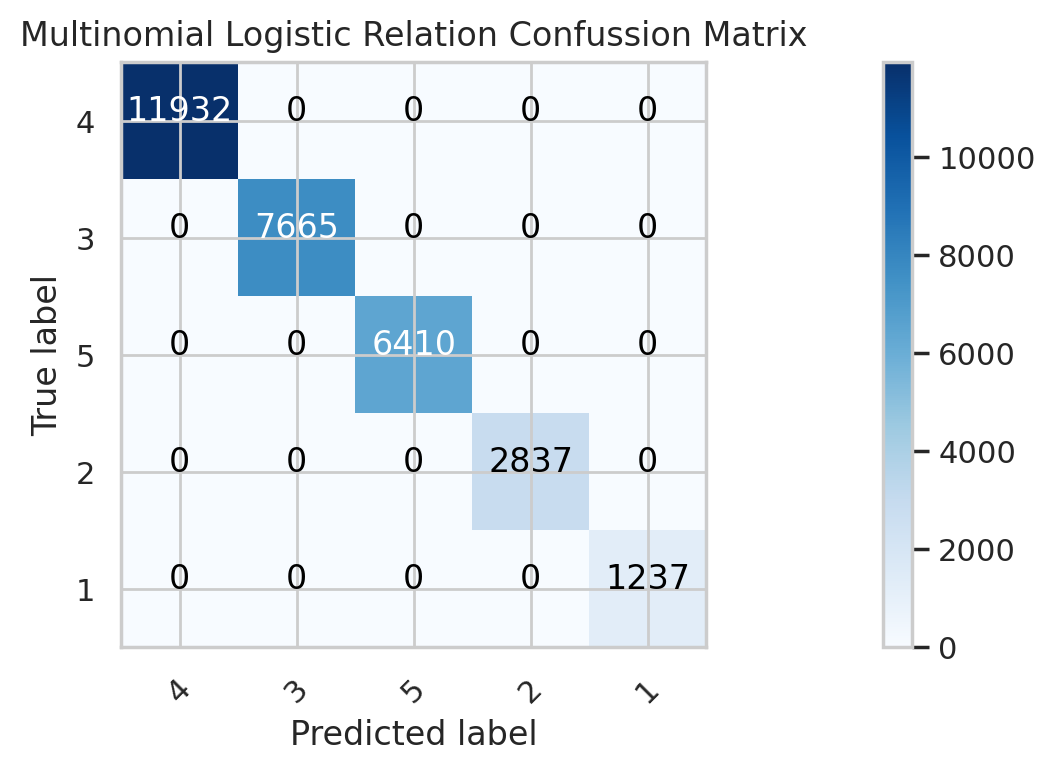

In [159]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

'''
lrModel = logRClassification.stages[2]
trainingSummary = lrModel.summary

#trainingSummary.roc.show(5)
#print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

fMeasure = trainingSummary.fMeasureByLabel
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head(5)


## ROC curve Plot

plt.figure(figsize=(5, 5))
plt.plot([0 , 1],[ 0, 1], 'r--')
plt.plot(trainingSummary.roc.select('FPR').collect(), trainingSummary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
'''

from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = []
for i in range(0, len(class_temp)):
    class_names.append(str(class_temp[i]))
class_names

cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
cnf_matrix

plt.figure()
cmap = plt.cm.Blues

plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
plt.title("Multinomial Logistic Relation Confussion Matrix")
plt.colorbar()
tick_makers = np.arange(len(class_temp))
plt.xticks(tick_makers, class_temp, rotation=45)
plt.yticks(tick_makers, class_temp)
thresh = cnf_matrix.max() /2
#fmt = '.2f'
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, format(cnf_matrix[i, j]),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.show()


I used the movieId, and rating features in this multinomial logistic regression. I figure it would make more sense to compare the ratings in the DataFrame per the movie titles as opposed to who rated what.

## Decision Tree Classifier

Decision trees and their ensembles are popular methods for the machine learning tasks of classification and regression. Decision trees are widely used since they are easy to interpret, handle categorical features, extend to the multiclass classification setting, do not require feature scaling, and are able to capture non-linearities and feature interactions. Tree ensemble algorithms such as random forests and boosting are among the top performers for classification and regression tasks.

The spark.ml implementation supports decision trees for binary and multiclass classification and for regression, using both continuous and categorical features. The implementation partitions data by rows, allowing distributed training with millions or even billions of instances.

A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.

Decision trees are commonly used in operations research, specifically in decision analysis, to help identify a strategy most likely to reach a goal, but are also a popular tool in machine learning.

For additional informaiton, please follow the link:
<a>https://scikit-learn.org/stable/modules/tree.html</a>

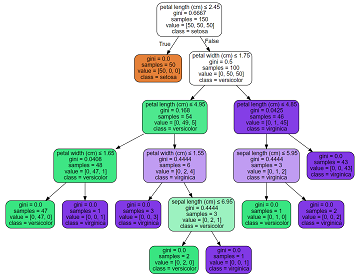

#### Step 1: SparkSession Creation and Library import

In [22]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, VectorIndexer, IndexToString, StringIndexer, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

# Spark Session Creation

ss = SparkSession.builder.master("local[4]").appName("Decision-Tree-Regression").getOrCreate()
sc = ss.sparkContext
sqlContext = SQLContext(sc)

#### Step 2: Data Loading and Data preprocessing

In [23]:
# Load data from file into dataframe
HOUSING_DATA = 'input/cal_housing.data'
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)
# Load housing data
housing_df = ss.read.csv(path=HOUSING_DATA, schema=schema).cache()

# Inspect first five rows
housing_df.take(5)

# show the dataframe columns
housing_df.columns

# Summary of the data

(housing_df.describe().select(
                    "summary",
                    F.round("medage", 4).alias("medage"),
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv"))
                    .show())


# Adjust the values of `medianHouseValue`
housing_df = housing_df.withColumn("medhv", col("medhv")/100000)


# Add the new columns to `df`
housing_df = (housing_df.withColumn("rmsperhh", F.round(col("totrooms")/col("houshlds"), 2))
                       .withColumn("popperhh", F.round(col("pop")/col("houshlds"), 2))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms")/col("totrooms"), 2)))

# Re-order and select columns
#housing_df = housing_df.select("medhv", 
#                               "medage",
#                              "totbdrms", 
#                              "pop", 
#                              "houshlds", 
#                              "medinc", 
#                              "rmsperhh", 
#                              "popperhh", 
#                              "bdrmsperrm")
## Feature group normalization
'''In Multinomial Regression classification, more than two classes can be classified. So, we need to create more classes/label data '''
housing_df = housing_df.withColumn("medhvRounded", 
                                   F.when((col("medhv") <=1), 0)
                                   .when((col("medhv") <= 2) & (col("medhv") > 1),1)
                                   .when((col("medhv") <= 3) & (col("medhv") > 2),2)
                                   .when((col("medhv") <= 4) & (col("medhv") > 3),3)
                                   .when((col("medhv") > 4),4))
housing_df.show(5)

[Row(long=-122.2300033569336, lat=37.880001068115234, medage=41.0, totrooms=880.0, totbdrms=129.0, pop=322.0, houshlds=126.0, medinc=8.325200080871582, medhv=452600.0),
 Row(long=-122.22000122070312, lat=37.86000061035156, medage=21.0, totrooms=7099.0, totbdrms=1106.0, pop=2401.0, houshlds=1138.0, medinc=8.301400184631348, medhv=358500.0),
 Row(long=-122.23999786376953, lat=37.849998474121094, medage=52.0, totrooms=1467.0, totbdrms=190.0, pop=496.0, houshlds=177.0, medinc=7.257400035858154, medhv=352100.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1274.0, totbdrms=235.0, pop=558.0, houshlds=219.0, medinc=5.643099784851074, medhv=341300.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1627.0, totbdrms=280.0, pop=565.0, houshlds=259.0, medinc=3.8461999893188477, medhv=342200.0)]

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20640.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631| 537.898|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.2479|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+



'In Multinomial Regression classification, more than two classes can be classified. So, we need to create more classes/label data '

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+------------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|medhvRounded|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+------------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|    6.98|    2.56|      0.15|           4|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|    6.24|    2.11|      0.16|           3|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|    8.29|     2.8|      0.13|           3|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|3.413|    5.82|    2.55|      0.18|           3|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|3.422|    6.28|    2.18|      0.17|           3|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+------

#### Step 3: Feature Selection and Decision Tree Classifier Model Creation

In [24]:
featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage"]

## Indexing creation for the featureCols .. This indexing gives us a mapping. 
indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in featureCols]

# encoder creation
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers]

# Use a VectorAssembler to put features into a feature vector column:
# put features into a feature vector column
assembler = VectorAssembler(inputCols= [encoder.getOutputCol() for encoder in encoders], outputCol="features")
pipeline = Pipeline(stages=indexers + encoders + [assembler])
assembled_df= pipeline.fit(housing_df).transform(housing_df)
assembled_df = assembled_df.withColumn('label', col('medhvRounded'))
assembled_df.show(5, truncate=False)

finalized_df = assembled_df.select("features", "label")
finalized_df.show(n=5)

quality_udf = udf(lambda x: x, StringType())
housing_df = housing_df.withColumn("label", quality_udf("medhvRounded"))

# Re-order and select columns
housing_df = housing_df.select("totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage", "label")


# We need to transform the dataset to Dataframe so that each class can be seperated perfectly.
transformed_df = housing_df.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])
transformed_df.show(5, truncate=False)

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+------------+----------------+-----------+----------------+--------------+----------------+----------------+------------------+--------------+------------------------+-------------------+------------------------+----------------------+------------------------+------------------------+--------------------------+----------------------+----------------------------------------------------------------------------------------+-----+
|long   |lat  |medage|totrooms|totbdrms|pop   |houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|medhvRounded|totbdrms_indexed|pop_indexed|houshlds_indexed|medinc_indexed|rmsperhh_indexed|popperhh_indexed|bdrmsperrm_indexed|medage_indexed|totbdrms_indexed_encoded|pop_indexed_encoded|houshlds_indexed_encoded|medinc_indexed_encoded|rmsperhh_indexed_encoded|popperhh_indexed_encoded|bdrmsperrm_indexed_encoded|medage_indexed_encoded|features                              

#### Step 4: Feature Selection for Better Mapping and Classification

In [25]:
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(transformed_df)
labelIndexer.transform(transformed_df).show(5, True)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=4).fit(transformed_df)
featureIndexer.transform(transformed_df).show(5, True)


+--------------------+-----+------------+
|            features|label|indexedLabel|
+--------------------+-----+------------+
|[129.0,322.0,126....|    4|         4.0|
|[1106.0,2401.0,11...|    3|         3.0|
|[190.0,496.0,177....|    3|         3.0|
|[235.0,558.0,219....|    3|         3.0|
|[280.0,565.0,259....|    3|         3.0|
+--------------------+-----+------------+
only showing top 5 rows

+--------------------+-----+--------------------+
|            features|label|     indexedFeatures|
+--------------------+-----+--------------------+
|[129.0,322.0,126....|    4|[129.0,322.0,126....|
|[1106.0,2401.0,11...|    3|[1106.0,2401.0,11...|
|[190.0,496.0,177....|    3|[190.0,496.0,177....|
|[235.0,558.0,219....|    3|[235.0,558.0,219....|
|[280.0,565.0,259....|    3|[280.0,565.0,259....|
+--------------------+-----+--------------------+
only showing top 5 rows



#### Step 5: Training and Testing data creation

In [26]:
# Split the data into training and test sets (30% held out for testing)

(train_Data, test_Data) = transformed_df.randomSplit([0.7, 0.3], seed=1234)

train_Data.show(5,False)
test_Data.show(5,False)

+---------------------------------------------------+-----+
|features                                           |label|
+---------------------------------------------------+-----+
|[2.0,8.0,2.0,1.625,3.0,4.0,0.33,1.0]               |0    |
|[3.0,5.0,3.0,0.5360000133514404,6.0,1.67,0.17,26.0]|2    |
|[3.0,11.0,3.0,5.047999858856201,5.0,3.67,0.2,26.0] |3    |
|[3.0,29.0,9.0,8.0,2.89,3.22,0.12,28.0]             |2    |
|[3.0,49.0,8.0,4.625,3.75,6.13,0.1,16.0]            |2    |
+---------------------------------------------------+-----+
only showing top 5 rows

+----------------------------------------------------+-----+
|features                                            |label|
+----------------------------------------------------+-----+
|[1.0,13.0,1.0,15.000100135803223,8.0,13.0,0.13,52.0]|4    |
|[2.0,6.0,2.0,2.375,1.0,3.0,1.0,4.0]                 |1    |
|[3.0,8.0,6.0,1.625,3.0,1.33,0.17,4.0]               |2    |
|[6.0,3.0,4.0,0.5360000133514404,4.5,0.75,0.33,16.0] |3    |
|[6.0,41

#### Step 6: Train the Mode and Fit with Decision Tree Classification

In [27]:
deccls = DecisionTreeClassifier(featuresCol='indexedFeatures', labelCol='indexedLabel')

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, deccls,labelConverter])

# Train model.  This also runs the indexers.
decisionTreeClassification = pipeline.fit(train_Data)

#### Step 7: Generate Predictions

In [28]:
predictions = decisionTreeClassification.transform(test_Data)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|[1.0,13.0,1.0,15....|    4|             4|
|[2.0,6.0,2.0,2.37...|    1|             1|
|[3.0,8.0,6.0,1.62...|    2|             0|
|[6.0,3.0,4.0,0.53...|    3|             1|
|[6.0,41.0,10.0,10...|    1|             4|
+--------------------+-----+--------------+
only showing top 5 rows



#### Step 8: Evaluation and Data Classification

Test Error = 0.448237
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b152653ae328, depth=5, numNodes=49, numClasses=5, numFeatures=8


['1', '2', '0', '3', '4']

array([[1843,  267,  269,   36,   17],
       [ 753,  478,   34,  162,   58],
       [ 470,   33,  593,    6,    1],
       [ 173,  152,    3,  185,  139],
       [  44,   56,    6,   92,  312]])

<Figure size 1800x400 with 0 Axes>

Text(0.5, 1.0, 'Decision Tree Relation Confussion Matrix')

([<matplotlib.axis.XTick at 0x7fe55c17d480>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '0'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

([<matplotlib.axis.YTick at 0x7fe557f14520>,
 [Text(0, 0, '1'),
  Text(0, 1, '2'),
  Text(0, 2, '0'),
  Text(0, 3, '3'),
  Text(0, 4, '4')])

Text(0, 0, '1843')

Text(1004.5000000000002, 0.5, 'True label')

Text(0.5, 7.749107165632944, 'Predicted label')

Text(1, 0, '267')

Text(1087.728670612145, 0.5, 'True label')

Text(0.5, 12.44444444444443, 'Predicted label')

Text(2, 0, '269')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 0, '36')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 0, '17')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 1, '753')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 1, '478')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 1, '34')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 1, '162')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 1, '58')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 2, '470')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 2, '33')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 2, '593')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 2, '6')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 2, '1')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 3, '173')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 3, '152')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 3, '3')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 3, '185')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 3, '139')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 4, '44')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 4, '56')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 4, '6')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 4, '92')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 4, '312')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

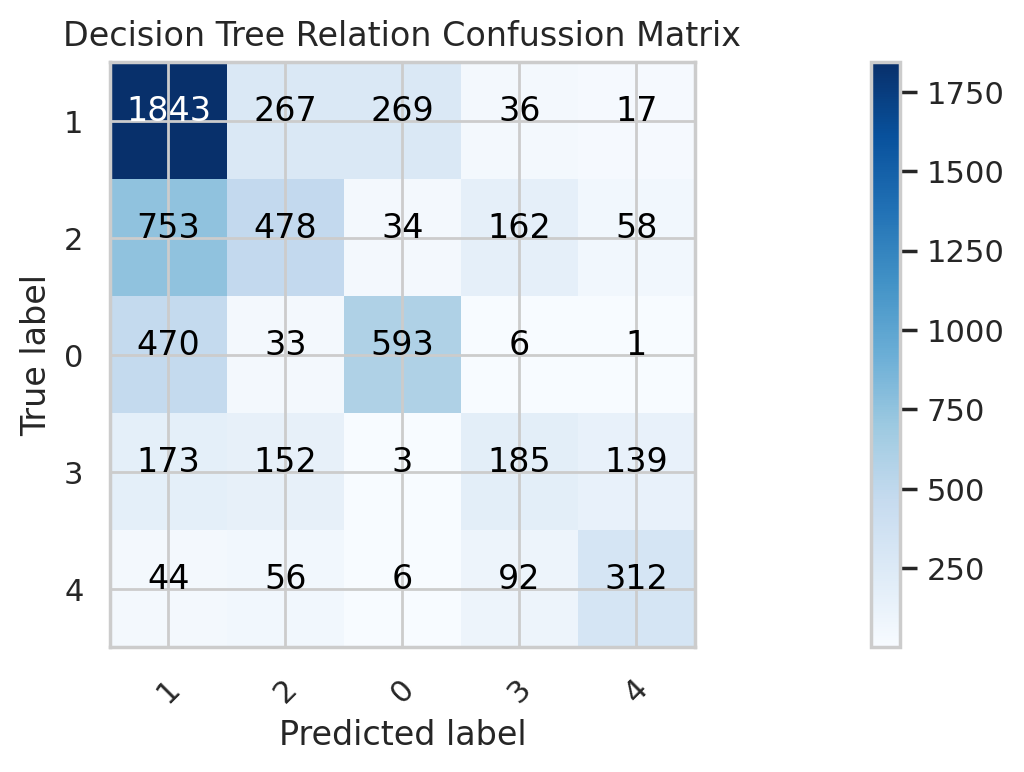

In [29]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = decisionTreeClassification.stages[-2]
print(rfModel)

#trainingSummary.roc.show(5)
#print("areaUnderROC: " + str(trainingSummary.areaUnderROC))


from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = []
for i in range(0, len(class_temp)):
    class_names.append(str(class_temp[i]))
class_names

cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
cnf_matrix

plt.figure()
cmap = plt.cm.Blues

plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
plt.title("Decision Tree Relation Confussion Matrix")
plt.colorbar()
tick_makers = np.arange(len(class_temp))
plt.xticks(tick_makers, class_temp, rotation=45)
plt.yticks(tick_makers, class_temp)
thresh = cnf_matrix.max() /2
#fmt = '.2f'
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, format(cnf_matrix[i, j]),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.show()

## Exercise 3

Can we redo the whole process of our highly used Movie Ratings dataset? Can we classify the movies based on their ratings?
Select which features we can use for decision tree classification. Explain why did you choose them.

In [164]:
moviesDF = ss.read.csv("Movies/movies.csv", header=True, inferSchema=True).cache()
ratingsDF = ss.read.csv("Movies/ratings.csv", header=True, inferSchema=True).cache()

joinedDF = moviesDF.join(ratingsDF, "movieId")

# Inspect first five rows
joinedDF.take(5)

# show the dataframe columns
joinedDF.columns

# Summary of the data

(joinedDF.describe().select(
                    "summary",
                    F.round("rating", 4).alias("rating"))
                    .show())

joinedDF = joinedDF.withColumn("ratingRounded", 
                                   F.when((col("rating") <= 1), 1)
                                   .when((col("rating") <= 2) & (col("rating") > 1), 2)
                                   .when((col("rating") <= 3) & (col("rating") > 2), 3)
                                   .when((col("rating") <= 4) & (col("rating") > 3), 4)
                                   .when((col("rating") > 4), 5))
joinedDF.show(5, truncate=False)

featureCols = ["movieId", "userId", "rating", "timestamp"]

indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in featureCols]
# encoder creation
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers]

# Use a VectorAssembler to put features into a feature vector column:
# put features into a feature vector column
assembler = VectorAssembler(inputCols= [encoder.getOutputCol() for encoder in encoders], outputCol="features")
pipeline = Pipeline(stages=indexers + encoders + [assembler])
joinedDF= pipeline.fit(joinedDF).transform(joinedDF)
joinedDF = joinedDF.withColumn('label', col('ratingRounded'))
joinedDF.show(5, truncate=False)

finalized_df = joinedDF.select("features", "label")
finalized_df.show(n=5)

quality_udf = udf(lambda x: x, StringType())
joinedDF = joinedDF.withColumn("label", quality_udf("ratingRounded"))

# Re-order and select columns
joinedDF = joinedDF.select("userId", "rating", "label")
joinedDF.show()

# We need to transform the dataset to Dataframe so that each class can be seperated perfectly.
joinedDF = joinedDF.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])
joinedDF.show(5, truncate=False)

# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(joinedDF)
labelIndexer.transform(joinedDF).show(5, True)

featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=5).fit(joinedDF)
featureIndexer.transform(joinedDF).show(5, True)


(train_Data, test_Data) = joinedDF.randomSplit([0.7, 0.3], seed=1234)

train_Data.show(5,False)
test_Data.show(5,False)

deccls = DecisionTreeClassifier(featuresCol='indexedFeatures', labelCol='indexedLabel')

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, deccls,labelConverter])

# Train model.  This also runs the indexers.
decisionTreeClassification = pipeline.fit(train_Data)

predictions = decisionTreeClassification.transform(test_Data)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

[Row(movieId=1, title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy', userId=1, rating=4.0, timestamp=964982703),
 Row(movieId=3, title='Grumpier Old Men (1995)', genres='Comedy|Romance', userId=1, rating=4.0, timestamp=964981247),
 Row(movieId=6, title='Heat (1995)', genres='Action|Crime|Thriller', userId=1, rating=4.0, timestamp=964982224),
 Row(movieId=47, title='Seven (a.k.a. Se7en) (1995)', genres='Mystery|Thriller', userId=1, rating=5.0, timestamp=964983815),
 Row(movieId=50, title='Usual Suspects, The (1995)', genres='Crime|Mystery|Thriller', userId=1, rating=5.0, timestamp=964982931)]

['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp']

+-------+--------+
|summary|  rating|
+-------+--------+
|  count|100836.0|
|   mean|  3.5016|
| stddev|  1.0425|
|    min|     0.5|
|    max|     5.0|
+-------+--------+

+-------+---------------------------+-------------------------------------------+------+------+---------+-------------+
|movieId|title                      |genres                                     |userId|rating|timestamp|ratingRounded|
+-------+---------------------------+-------------------------------------------+------+------+---------+-------------+
|1      |Toy Story (1995)           |Adventure|Animation|Children|Comedy|Fantasy|1     |4.0   |964982703|4            |
|3      |Grumpier Old Men (1995)    |Comedy|Romance                             |1     |4.0   |964981247|4            |
|6      |Heat (1995)                |Action|Crime|Thriller                      |1     |4.0   |964982224|4            |
|47     |Seven (a.k.a. Se7en) (1995)|Mystery|Thriller                           |1     |5.0   |964983815|5  

Test Error = 0
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_bb31ea69948a, depth=3, numNodes=9, numClasses=5, numFeatures=2


['4', '3', '5', '2', '1']

array([[11818,     0,     0,     0,     0],
       [    0,  7696,     0,     0,     0],
       [    0,     0,  6538,     0,     0],
       [    0,     0,     0,  2798,     0],
       [    0,     0,     0,     0,  1231]])

<Figure size 1800x400 with 0 Axes>

Text(0.5, 1.0, 'Decision Tree Relation Confussion Matrix')

([<matplotlib.axis.XTick at 0x7fe542b74100>,
 [Text(0, 0, '4'),
  Text(1, 0, '3'),
  Text(2, 0, '5'),
  Text(3, 0, '2'),
  Text(4, 0, '1')])

([<matplotlib.axis.YTick at 0x7fe543060070>,
 [Text(0, 0, '4'),
  Text(0, 1, '3'),
  Text(0, 2, '5'),
  Text(0, 3, '2'),
  Text(0, 4, '1')])

Text(0, 0, '11818')

Text(1004.5000000000002, 0.5, 'True label')

Text(0.5, 7.749107165632944, 'Predicted label')

Text(1, 0, '0')

Text(1087.728670612145, 0.5, 'True label')

Text(0.5, 12.44444444444443, 'Predicted label')

Text(2, 0, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 0, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 0, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 1, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 1, '7696')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 1, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 1, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 1, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 2, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 2, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 2, '6538')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 2, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 2, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 3, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 3, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 3, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 3, '2798')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 3, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 4, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 4, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 4, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 4, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 4, '1231')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

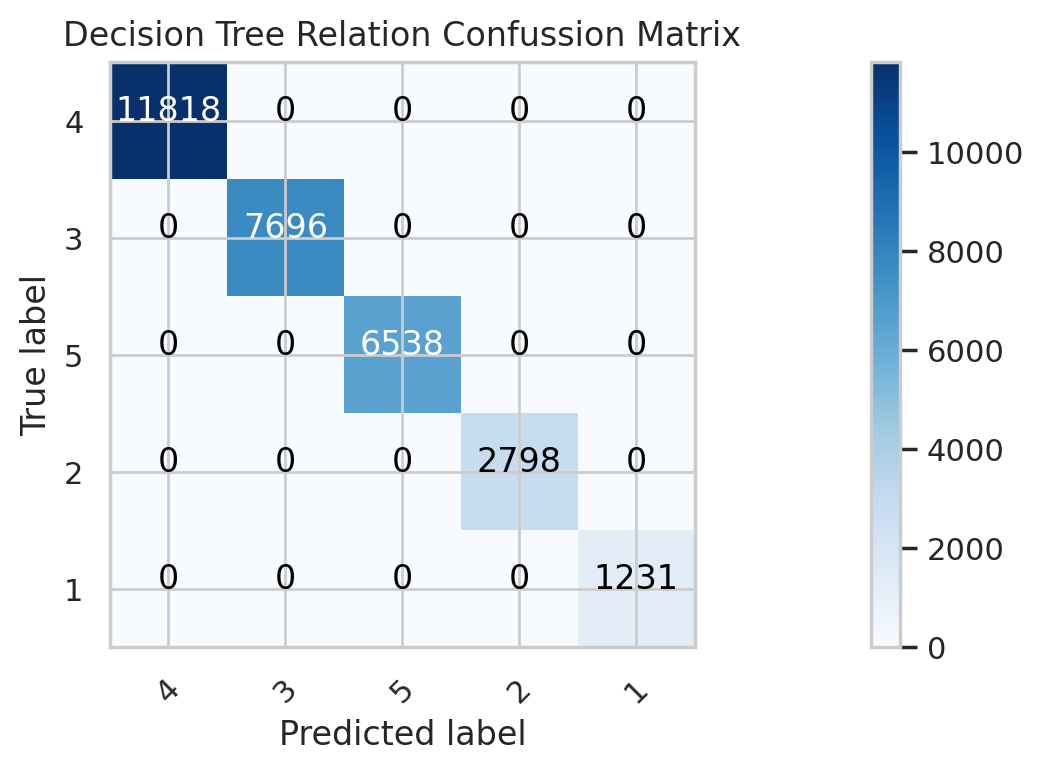

In [166]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = decisionTreeClassification.stages[-2]
print(rfModel)

#trainingSummary.roc.show(5)
#print("areaUnderROC: " + str(trainingSummary.areaUnderROC))


from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = []
for i in range(0, len(class_temp)):
    class_names.append(str(class_temp[i]))
class_names

cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
cnf_matrix

plt.figure()
cmap = plt.cm.Blues

plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
plt.title("Decision Tree Relation Confussion Matrix")
plt.colorbar()
tick_makers = np.arange(len(class_temp))
plt.xticks(tick_makers, class_temp, rotation=45)
plt.yticks(tick_makers, class_temp)
thresh = cnf_matrix.max() /2
#fmt = '.2f'
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, format(cnf_matrix[i, j]),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.show()

I used the userId and rating fields to do the decision tree classification. The reason for this is that I just wanted to see the relationship between those 2 fields in this classification, as I went with movieId and rating for the previous 2 models.

# Random Forest Classification

Random forests are a popular family of classification and regression methods. Random forests are ensembles of decision trees. Random forests combine many decision trees in order to reduce the risk of overfitting. The spark.ml implementation supports random forests for binary and multiclass classification and for regression, using both continuous and categorical features.

Random forests or random decision forests is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees. For regression tasks, the mean or average prediction of the individual trees is returned. Random decision forests correct for decision trees' habit of overfitting to their training set. Random forests generally outperform decision trees, but their accuracy is lower than gradient boosted trees.[citation needed] However, data characteristics can affect their performance.

To know more about Random Forest, you can follow the link attached here:
    <a>https://www.ibm.com/topics/random-forest</a>
    
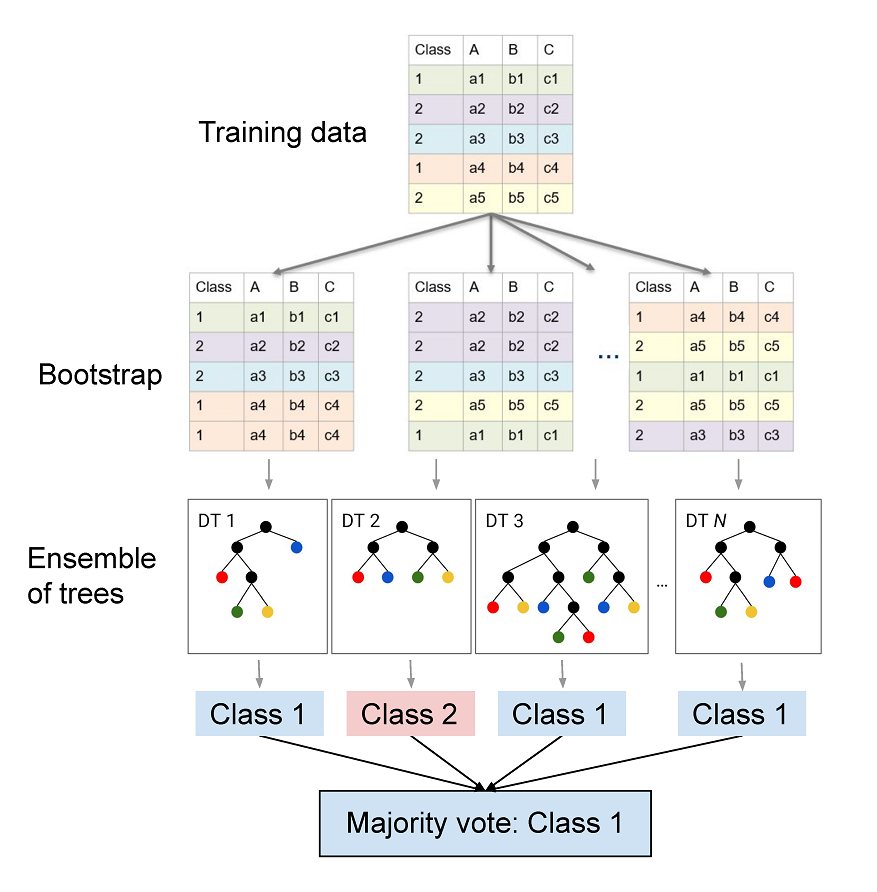

#### Step 1: SparkSession Creation and Library import

In [30]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.classification import RandomForestClassifier
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, VectorIndexer, IndexToString, StringIndexer, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

# Spark Session Creation

ss = SparkSession.builder.master("local[4]").appName("Random-Forest-Regression").getOrCreate()
sc = ss.sparkContext
sqlContext = SQLContext(sc)

/usr/local/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


#### Step 2: Data Loading and Data preprocessing

In [31]:
# Load data from file into dataframe
HOUSING_DATA = 'input/cal_housing.data'
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)
# Load housing data
housing_df = ss.read.csv(path=HOUSING_DATA, schema=schema).cache()

# Inspect first five rows
housing_df.take(5)

# show the dataframe columns
housing_df.columns

# Summary of the data

(housing_df.describe().select(
                    "summary",
                    F.round("medage", 4).alias("medage"),
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv"))
                    .show())


# Adjust the values of `medianHouseValue`
housing_df = housing_df.withColumn("medhv", col("medhv")/100000)


# Add the new columns to `df`
housing_df = (housing_df.withColumn("rmsperhh", F.round(col("totrooms")/col("houshlds"), 2))
                       .withColumn("popperhh", F.round(col("pop")/col("houshlds"), 2))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms")/col("totrooms"), 2)))


## Feature group normalization
housing_df = housing_df.withColumn("medhvRounded", 
                                   F.when((col("medhv") <=1), 0)
                                   .when((col("medhv") <= 2) & (col("medhv") > 1),1)
                                   .when((col("medhv") <= 3) & (col("medhv") > 2),2)
                                   .when((col("medhv") <= 4) & (col("medhv") > 3),3)
                                   .when((col("medhv") > 4),4))
housing_df.show(5)

[Row(long=-122.2300033569336, lat=37.880001068115234, medage=41.0, totrooms=880.0, totbdrms=129.0, pop=322.0, houshlds=126.0, medinc=8.325200080871582, medhv=452600.0),
 Row(long=-122.22000122070312, lat=37.86000061035156, medage=21.0, totrooms=7099.0, totbdrms=1106.0, pop=2401.0, houshlds=1138.0, medinc=8.301400184631348, medhv=358500.0),
 Row(long=-122.23999786376953, lat=37.849998474121094, medage=52.0, totrooms=1467.0, totbdrms=190.0, pop=496.0, houshlds=177.0, medinc=7.257400035858154, medhv=352100.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1274.0, totbdrms=235.0, pop=558.0, houshlds=219.0, medinc=5.643099784851074, medhv=341300.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1627.0, totbdrms=280.0, pop=565.0, houshlds=259.0, medinc=3.8461999893188477, medhv=342200.0)]

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20640.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631| 537.898|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.2479|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+------------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|medhvRounded|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----

#### Step 3: Feature Selection and Random Forest Classifier Model Creation

In [32]:
featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage"]

## Indexing creation for the featureCols .. This indexing gives us a mapping. 
indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in featureCols]

# encoder creation
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers]

# Use a VectorAssembler to put features into a feature vector column:
# put features into a feature vector column
assembler = VectorAssembler(inputCols= [encoder.getOutputCol() for encoder in encoders], outputCol="features")
pipeline = Pipeline(stages=indexers + encoders + [assembler])
assembled_df= pipeline.fit(housing_df).transform(housing_df)
assembled_df = assembled_df.withColumn('label', col('medhvRounded'))
assembled_df.show(5, truncate=False)

finalized_df = assembled_df.select("features", "label")
finalized_df.show(n=5)

quality_udf = udf(lambda x: x, StringType())
housing_df = housing_df.withColumn("label", quality_udf("medhvRounded"))

# Re-order and select columns
housing_df = housing_df.select("totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage", "label")


# We need to transform the dataset to Dataframe so that each class can be seperated perfectly.
transformed_df = housing_df.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])
transformed_df.show(5, truncate=False)

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+------------+----------------+-----------+----------------+--------------+----------------+----------------+------------------+--------------+------------------------+-------------------+------------------------+----------------------+------------------------+------------------------+--------------------------+----------------------+----------------------------------------------------------------------------------------+-----+
|long   |lat  |medage|totrooms|totbdrms|pop   |houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|medhvRounded|totbdrms_indexed|pop_indexed|houshlds_indexed|medinc_indexed|rmsperhh_indexed|popperhh_indexed|bdrmsperrm_indexed|medage_indexed|totbdrms_indexed_encoded|pop_indexed_encoded|houshlds_indexed_encoded|medinc_indexed_encoded|rmsperhh_indexed_encoded|popperhh_indexed_encoded|bdrmsperrm_indexed_encoded|medage_indexed_encoded|features                              

#### Step 4: Feature Indexing for Better Mapping and Classification

In [33]:
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(transformed_df)
labelIndexer.transform(transformed_df).show(5, True)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=4).fit(transformed_df)
featureIndexer.transform(transformed_df).show(5, True)

+--------------------+-----+------------+
|            features|label|indexedLabel|
+--------------------+-----+------------+
|[129.0,322.0,126....|    4|         4.0|
|[1106.0,2401.0,11...|    3|         3.0|
|[190.0,496.0,177....|    3|         3.0|
|[235.0,558.0,219....|    3|         3.0|
|[280.0,565.0,259....|    3|         3.0|
+--------------------+-----+------------+
only showing top 5 rows

+--------------------+-----+--------------------+
|            features|label|     indexedFeatures|
+--------------------+-----+--------------------+
|[129.0,322.0,126....|    4|[129.0,322.0,126....|
|[1106.0,2401.0,11...|    3|[1106.0,2401.0,11...|
|[190.0,496.0,177....|    3|[190.0,496.0,177....|
|[235.0,558.0,219....|    3|[235.0,558.0,219....|
|[280.0,565.0,259....|    3|[280.0,565.0,259....|
+--------------------+-----+--------------------+
only showing top 5 rows



#### Step 5: Training and Testing data creation

In [34]:
# Split the data into training and test sets (30% held out for testing)

(train_Data, test_Data) = transformed_df.randomSplit([0.7, 0.3], seed=1234)

train_Data.show(5,False)
test_Data.show(5,False)

+---------------------------------------------------+-----+
|features                                           |label|
+---------------------------------------------------+-----+
|[2.0,8.0,2.0,1.625,3.0,4.0,0.33,1.0]               |0    |
|[3.0,5.0,3.0,0.5360000133514404,6.0,1.67,0.17,26.0]|2    |
|[3.0,11.0,3.0,5.047999858856201,5.0,3.67,0.2,26.0] |3    |
|[3.0,29.0,9.0,8.0,2.89,3.22,0.12,28.0]             |2    |
|[3.0,49.0,8.0,4.625,3.75,6.13,0.1,16.0]            |2    |
+---------------------------------------------------+-----+
only showing top 5 rows

+----------------------------------------------------+-----+
|features                                            |label|
+----------------------------------------------------+-----+
|[1.0,13.0,1.0,15.000100135803223,8.0,13.0,0.13,52.0]|4    |
|[2.0,6.0,2.0,2.375,1.0,3.0,1.0,4.0]                 |1    |
|[3.0,8.0,6.0,1.625,3.0,1.33,0.17,4.0]               |2    |
|[6.0,3.0,4.0,0.5360000133514404,4.5,0.75,0.33,16.0] |3    |
|[6.0,41

#### Step 6: Train the Mode and Fit with Decision Tree Classification


In [35]:
randFrCls = RandomForestClassifier(featuresCol='indexedFeatures', labelCol='indexedLabel')

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, randFrCls,labelConverter])

# Train model.  This also runs the indexers.
randFrstClassification = pipeline.fit(train_Data)

#### Step 7: Generate Predictions

In [36]:
predictions = randFrstClassification.transform(test_Data)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|[1.0,13.0,1.0,15....|    4|             4|
|[2.0,6.0,2.0,2.37...|    1|             1|
|[3.0,8.0,6.0,1.62...|    2|             1|
|[6.0,3.0,4.0,0.53...|    3|             0|
|[6.0,41.0,10.0,10...|    1|             4|
+--------------------+-----+--------------+
only showing top 5 rows



#### Step 8: Evaluation and Data Classification

Test Error = 0.452119
RandomForestClassificationModel: uid=RandomForestClassifier_1f49b600e258, numTrees=20, numClasses=5, numFeatures=8


['1', '2', '0', '3', '4']

array([[2029,  189,  205,    2,    7],
       [ 892,  531,   21,   25,   16],
       [ 583,    4,  516,    0,    0],
       [ 225,  287,    3,   58,   79],
       [  74,  157,    4,   22,  253]])

<Figure size 1800x400 with 0 Axes>

Text(0.5, 1.0, 'Random Forest Relation Confussion Matrix')

([<matplotlib.axis.XTick at 0x7fe55c17e8c0>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '0'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

([<matplotlib.axis.YTick at 0x7fe55c174490>,
 [Text(0, 0, '1'),
  Text(0, 1, '2'),
  Text(0, 2, '0'),
  Text(0, 3, '3'),
  Text(0, 4, '4')])

Text(0, 0, '2029')

Text(1004.5000000000002, 0.5, 'True label')

Text(0.5, 7.749107165632944, 'Predicted label')

Text(1, 0, '189')

Text(1087.728670612145, 0.5, 'True label')

Text(0.5, 12.44444444444443, 'Predicted label')

Text(2, 0, '205')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 0, '2')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 0, '7')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 1, '892')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 1, '531')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 1, '21')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 1, '25')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 1, '16')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 2, '583')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 2, '4')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 2, '516')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 2, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 2, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 3, '225')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 3, '287')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 3, '3')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 3, '58')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 3, '79')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 4, '74')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 4, '157')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 4, '4')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 4, '22')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 4, '253')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

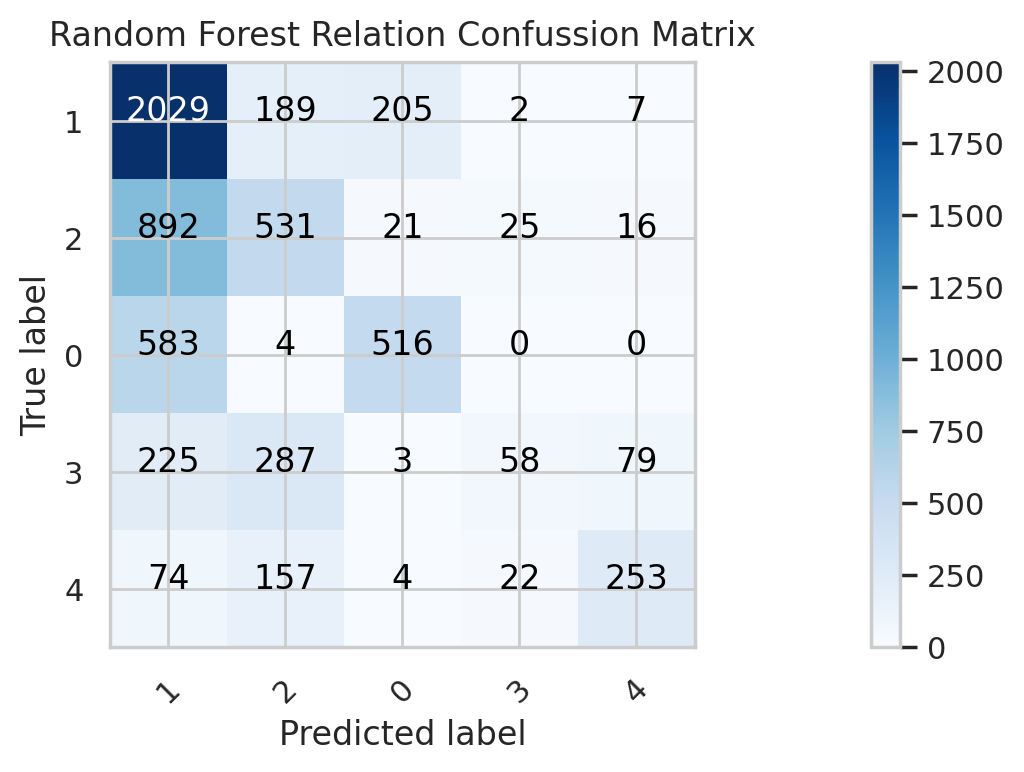

In [37]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = randFrstClassification.stages[-2]
print(rfModel)

#trainingSummary.roc.show(5)
#print("areaUnderROC: " + str(trainingSummary.areaUnderROC))


from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = []
for i in range(0, len(class_temp)):
    class_names.append(str(class_temp[i]))
class_names

cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
cnf_matrix

plt.figure()
cmap = plt.cm.Blues

plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
plt.title("Random Forest Relation Confussion Matrix")
plt.colorbar()
tick_makers = np.arange(len(class_temp))
plt.xticks(tick_makers, class_temp, rotation=45)
plt.yticks(tick_makers, class_temp)
thresh = cnf_matrix.max() /2
#fmt = '.2f'
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, format(cnf_matrix[i, j]),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.show()

## Exercise 4

Can we redo the whole process of our highly used Movie Ratings dataset? Can we classify the movies based on their ratings?
Select which features we can use for Random forest regression classification. Explain why did you choose them.

# Gradient Boosting Classifier

Usually, you may have a few good predictors, and you would like to use them all, instead of painfully choosing one because it has a 0.0001 accuracy increase. In comes Ensemble Learning. In Ensemble Learning, instead of using a single predictor, multiple predictors and training in the data and their results are aggregated, usually giving a better score than using a single model. A Random Forest, for instance, is simply an ensemble of bagged(or pasted) Decision Trees.

You can think of Ensemble Methods as an orchestra; instead of just having one person play an instrument, multiple people play different instruments, and by combining all the musical groups, the music sound generally better than it would if it was played by a single person.

While Gradient Boosting is an Ensemble Learning method, it is more specifically a Boosting Technique. So, what’s Boosting?

#### Boosting
Boosting is a special type of Ensemble Learning technique that works by combining several weak learners(predictors with poor accuracy) into a strong learner(a model with strong accuracy). This works by each model paying attention to its predecessor’s mistakes.

The two most popular boosting methods are:

Adaptive Boosting(you can read my article about it here)

#### Gradient Boosting
In Gradient Boosting, each predictor tries to improve on its predecessor by reducing the errors. But the fascinating idea behind Gradient Boosting is that instead of fitting a predictor on the data at each iteration, it actually fits a new predictor to the residual errors made by the previous predictor. 

In order to make initial predictions on the data, the algorithm will get the log of the odds of the target feature. This is usually the number of True values(values equal to 1) divided by the number of False values(values equal to 0).

Once it has the log(odds), we convert that value to a probability by using a logistic function in order to make predictions. If we are continuing with our previous example of a log(odds) value of 0.7, then the logistic function would equate to around 0.7 too.

e * log(odds) / (1 + e * log(odds))

For every instance in the training set, it calculates the residuals for that instance, or, in other words, the observed value minus the predicted value.
Once it has done this, it build a new Decision Tree that actually tries to predict the residuals that was previously calculated. However, this is where it gets slightly tricky in comparison with Gradient Boosting Regression.
When building a Decision Tree, there is a set number of leaves allowed. This can be set as a parameter by a user, and it is usually between 8 and 32. This leads to two of the possible outcomes:

<ul>
<li>Multiple instances fall into the same leaf</li>
<li>A single instance has its own leaf</li>
</ul>
Unlike Gradient Boosting for Regression, where we could simply average the instance values to get an output value, and leave the single instance as a leaf of its own, we have to transform these values using a formula:

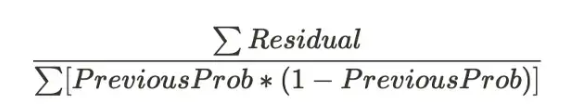

The Σ sign means “sum of”, and PreviousProb refers to our previously calculated probability(in our example, being 0.7). We apply this transformation for every leaf in the tree. Why do we do this? Because remember our base estimator is a log(odds), and our tree was actually built on a probability, so we cannot simply add them because they come from two different sources.

#### Making Predictions
Now, to make new predictions, we do 2 things:
<ol>
<li>get the log(odds) prediction for each instance in the training set</li>
<li>convert that prediction into a probability</li>
</ol>
For each instance in the training set, the formula for making predictions would be the following:

base_log_odds + (learning_rate * predicted residual value)

The learning_rate is a hyperparameter that is used to scale each trees contribution, sacrificing bias for better variance. In other words, we multiply this number by the predicted value so that we do not overfit the data.

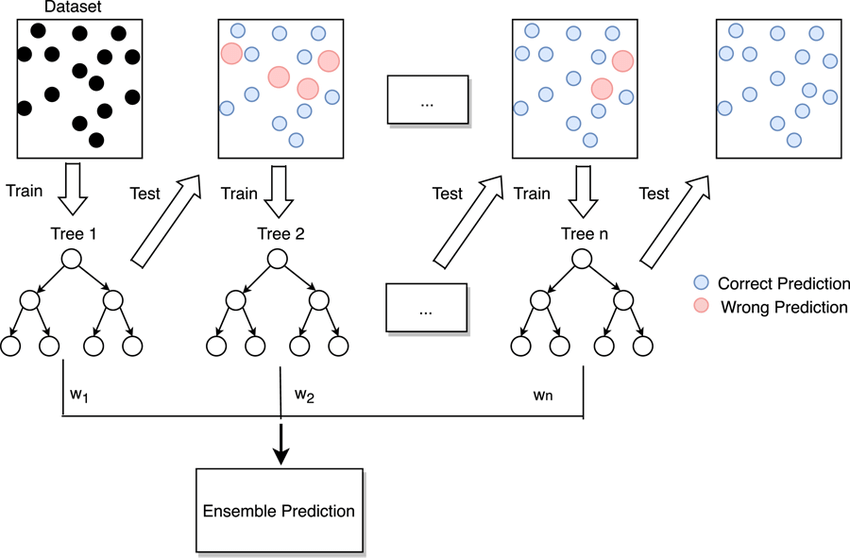

#### Step 1: SparkSession Creation and Library Imports

In [38]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.classification import GBTClassifier
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, VectorIndexer, IndexToString, StringIndexer, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

# Spark Session Creation

ss = SparkSession.builder.master("local[4]").appName("Random-Forest-Regression").getOrCreate()
sc = ss.sparkContext
sqlContext = SQLContext(sc)

/usr/local/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


#### Step 2: Data Loading and Data Preprocessing

In [39]:
# Load data from file into dataframe
HOUSING_DATA = 'input/cal_housing.data'
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)
# Load housing data
housing_df = ss.read.csv(path=HOUSING_DATA, schema=schema).cache()

# Inspect first five rows
housing_df.take(5)

# show the dataframe columns
housing_df.columns

# Summary of the data

(housing_df.describe().select(
                    "summary",
                    F.round("medage", 4).alias("medage"),
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv"))
                    .show())


# Adjust the values of `medianHouseValue`
housing_df = housing_df.withColumn("medhv", col("medhv")/100000)


# Add the new columns to `df`
housing_df = (housing_df.withColumn("rmsperhh", F.round(col("totrooms")/col("houshlds"), 2))
                       .withColumn("popperhh", F.round(col("pop")/col("houshlds"), 2))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms")/col("totrooms"), 2)))


## Feature group normalization .. GBT only supports binary classification. So we need to divide the data in two labels only
housing_df = housing_df.withColumn("medhvRounded", F.when((col("medhv") <=3.0), 0).when((col("medhv") > 3.0),1))
housing_df.show(5)

[Row(long=-122.2300033569336, lat=37.880001068115234, medage=41.0, totrooms=880.0, totbdrms=129.0, pop=322.0, houshlds=126.0, medinc=8.325200080871582, medhv=452600.0),
 Row(long=-122.22000122070312, lat=37.86000061035156, medage=21.0, totrooms=7099.0, totbdrms=1106.0, pop=2401.0, houshlds=1138.0, medinc=8.301400184631348, medhv=358500.0),
 Row(long=-122.23999786376953, lat=37.849998474121094, medage=52.0, totrooms=1467.0, totbdrms=190.0, pop=496.0, houshlds=177.0, medinc=7.257400035858154, medhv=352100.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1274.0, totbdrms=235.0, pop=558.0, houshlds=219.0, medinc=5.643099784851074, medhv=341300.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1627.0, totbdrms=280.0, pop=565.0, houshlds=259.0, medinc=3.8461999893188477, medhv=342200.0)]

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20640.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631| 537.898|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.2479|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+------------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|medhvRounded|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----

#### Step 3: Feature Selection and Gradient Boost Tree Classifier

In [40]:
featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage"]

## Indexing creation for the featureCols .. This indexing gives us a mapping. 
indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in featureCols]

# encoder creation
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers]

# Use a VectorAssembler to put features into a feature vector column:
# put features into a feature vector column
assembler = VectorAssembler(inputCols= [encoder.getOutputCol() for encoder in encoders], outputCol="features")
pipeline = Pipeline(stages=indexers + encoders + [assembler])
assembled_df= pipeline.fit(housing_df).transform(housing_df)
assembled_df = assembled_df.withColumn('label', col('medhvRounded'))
assembled_df.show(5, truncate=False)

finalized_df = assembled_df.select("features", "label")
finalized_df.show(n=5)

quality_udf = udf(lambda x: x, StringType())
housing_df = housing_df.withColumn("label", quality_udf("medhvRounded"))

# Re-order and select columns
housing_df = housing_df.select("totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage", "label")


# We need to transform the dataset to Dataframe so that each class can be seperated perfectly.
transformed_df = housing_df.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])
transformed_df.show(5, truncate=False)

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+------------+----------------+-----------+----------------+--------------+----------------+----------------+------------------+--------------+------------------------+-------------------+------------------------+----------------------+------------------------+------------------------+--------------------------+----------------------+----------------------------------------------------------------------------------------+-----+
|long   |lat  |medage|totrooms|totbdrms|pop   |houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|medhvRounded|totbdrms_indexed|pop_indexed|houshlds_indexed|medinc_indexed|rmsperhh_indexed|popperhh_indexed|bdrmsperrm_indexed|medage_indexed|totbdrms_indexed_encoded|pop_indexed_encoded|houshlds_indexed_encoded|medinc_indexed_encoded|rmsperhh_indexed_encoded|popperhh_indexed_encoded|bdrmsperrm_indexed_encoded|medage_indexed_encoded|features                              

#### Step 4: Feature Indexing for better classification mapping

In [41]:
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(transformed_df)
labelIndexer.transform(transformed_df).show(5, True)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=4).fit(transformed_df)
featureIndexer.transform(transformed_df).show(5, True)

+--------------------+-----+------------+
|            features|label|indexedLabel|
+--------------------+-----+------------+
|[129.0,322.0,126....|    1|         1.0|
|[1106.0,2401.0,11...|    1|         1.0|
|[190.0,496.0,177....|    1|         1.0|
|[235.0,558.0,219....|    1|         1.0|
|[280.0,565.0,259....|    1|         1.0|
+--------------------+-----+------------+
only showing top 5 rows

+--------------------+-----+--------------------+
|            features|label|     indexedFeatures|
+--------------------+-----+--------------------+
|[129.0,322.0,126....|    1|[129.0,322.0,126....|
|[1106.0,2401.0,11...|    1|[1106.0,2401.0,11...|
|[190.0,496.0,177....|    1|[190.0,496.0,177....|
|[235.0,558.0,219....|    1|[235.0,558.0,219....|
|[280.0,565.0,259....|    1|[280.0,565.0,259....|
+--------------------+-----+--------------------+
only showing top 5 rows



#### Step 5: Training and Testing Data Creation

In [42]:
# Split the data into training and test sets (30% held out for testing)

(train_Data, test_Data) = transformed_df.randomSplit([0.7, 0.3], seed=1234)

train_Data.show(5,False)
test_Data.show(5,False)

+---------------------------------------------------+-----+
|features                                           |label|
+---------------------------------------------------+-----+
|[2.0,8.0,2.0,1.625,3.0,4.0,0.33,1.0]               |0    |
|[3.0,5.0,3.0,0.5360000133514404,6.0,1.67,0.17,26.0]|0    |
|[3.0,11.0,3.0,5.047999858856201,5.0,3.67,0.2,26.0] |1    |
|[3.0,29.0,9.0,8.0,2.89,3.22,0.12,28.0]             |0    |
|[3.0,49.0,8.0,4.625,3.75,6.13,0.1,16.0]            |0    |
+---------------------------------------------------+-----+
only showing top 5 rows

+----------------------------------------------------+-----+
|features                                            |label|
+----------------------------------------------------+-----+
|[1.0,13.0,1.0,15.000100135803223,8.0,13.0,0.13,52.0]|1    |
|[2.0,6.0,2.0,2.375,1.0,3.0,1.0,4.0]                 |0    |
|[3.0,8.0,6.0,1.625,3.0,1.33,0.17,4.0]               |0    |
|[6.0,3.0,4.0,0.5360000133514404,4.5,0.75,0.33,16.0] |1    |
|[6.0,41

#### Step 6: Train the Model and fit the Gradient Booster Classifier

In [43]:
gbtCls = GBTClassifier(featuresCol='indexedFeatures', labelCol='indexedLabel')

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbtCls,labelConverter])

# Train model.  This also runs the indexers.
gbtClassification = pipeline.fit(train_Data)

#### Step 7: Generating Predictions

In [44]:
predictions = gbtClassification.transform(test_Data)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|[1.0,13.0,1.0,15....|    1|             1|
|[2.0,6.0,2.0,2.37...|    0|             0|
|[3.0,8.0,6.0,1.62...|    0|             0|
|[6.0,3.0,4.0,0.53...|    1|             0|
|[6.0,41.0,10.0,10...|    0|             1|
+--------------------+-----+--------------+
only showing top 5 rows



#### Step 8: Evaluation and Data Classification

Test Error = 0.111129
GBTClassificationModel: uid = GBTClassifier_58d8fcf91621, numTrees=20, numClasses=2, numFeatures=8


['0', '1']

array([[4804,  216],
       [ 471,  691]])

<Figure size 1800x400 with 0 Axes>

Text(0.5, 1.0, 'Random Forest Relation Confussion Matrix')

([<matplotlib.axis.XTick at 0x7fe557fbd3f0>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

([<matplotlib.axis.YTick at 0x7fe557fbd690>,
 [Text(0, 0, '0'), Text(0, 1, '1')])

Text(0, 0, '4804')

Text(1004.5000000000002, 0.5, 'True label')

Text(0.5, 7.749107165632944, 'Predicted label')

Text(1, 0, '216')

Text(1087.728670612145, 0.5, 'True label')

Text(0.5, 12.44444444444443, 'Predicted label')

Text(0, 1, '471')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 1, '691')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

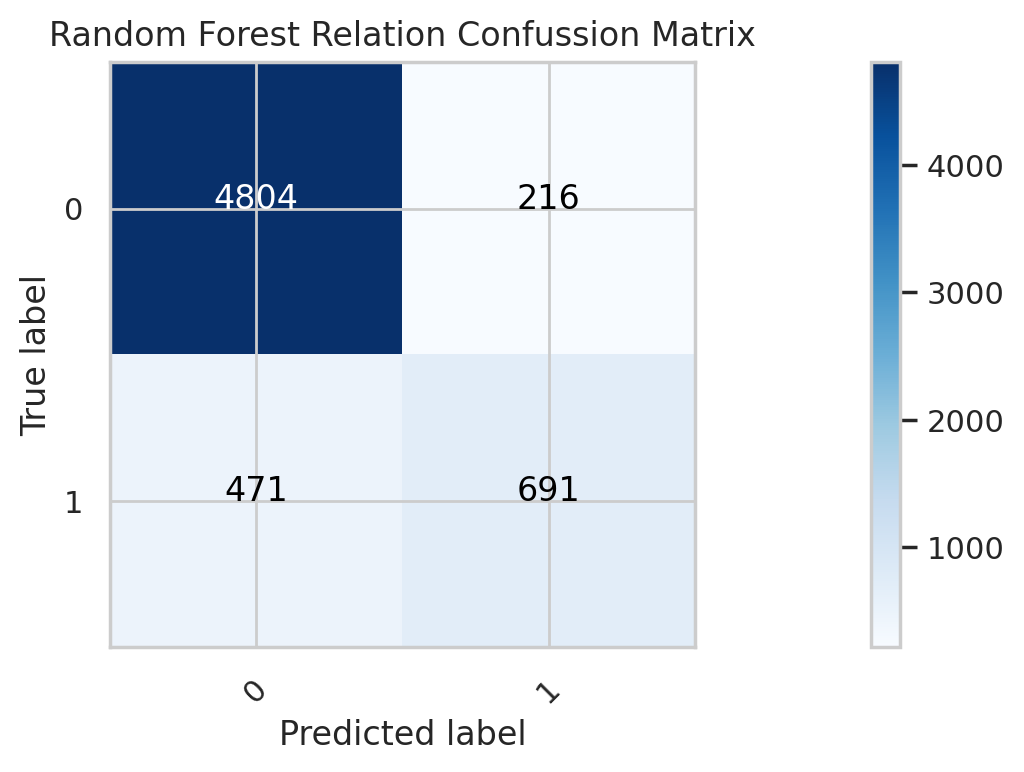

In [45]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = gbtClassification.stages[-2]
print(rfModel)

#trainingSummary.roc.show(5)
#print("areaUnderROC: " + str(trainingSummary.areaUnderROC))


from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = []
for i in range(0, len(class_temp)):
    class_names.append(str(class_temp[i]))
class_names

cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
cnf_matrix

plt.figure()
cmap = plt.cm.Blues

plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
plt.title("Random Forest Relation Confussion Matrix")
plt.colorbar()
tick_makers = np.arange(len(class_temp))
plt.xticks(tick_makers, class_temp, rotation=45)
plt.yticks(tick_makers, class_temp)
thresh = cnf_matrix.max() /2
#fmt = '.2f'
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, format(cnf_matrix[i, j]),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.show()

In [46]:
Exercise 6

Can we redo the whole process of our highly used Movie Ratings dataset? Can we classify the movies based on their ratings?
Select which features we can use for Gradient boosting regression classification. Explain why did you choose them.

SyntaxError: invalid syntax (491324970.py, line 1)

# Linear Support Vector Machine

A support vector machine constructs a hyperplane or set of hyperplanes in a high- or infinite-dimensional space, which can be used for classification, regression, or other tasks. Intuitively, a good separation is achieved by the hyperplane that has the largest distance to the nearest training-data points of any class (so-called functional margin), since in general the larger the margin the lower the generalization error of the classifier. LinearSVC in Spark ML supports binary classification with linear SVM. Internally, it optimizes the Hinge Loss using OWLQN optimizer.

<strong>Support vector machines (SVMs)</strong> are a set of supervised learning methods used for classification, regression and outliers detection.

The advantages of support vector machines are:

<ul>
<li>Effective in high dimensional spaces.</li>

<li>Still effective in cases where number of dimensions is greater than the number of samples.</li>

<li>Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.</li>

<li>Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.</li>
</ul>

The disadvantages of support vector machines include:
<ul>
<li>If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.</li>

<li>SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation (see Scores and probabilities, below).</li>
</ul>

The support vector machines in scikit-learn support both dense (numpy.ndarray and convertible to that by numpy.asarray) and sparse (any scipy.sparse) sample vectors as input. However, to use an SVM to make predictions for sparse data, it must have been fit on such data. For optimal performance, use C-ordered numpy.ndarray (dense) or scipy.sparse.csr_matrix (sparse) with dtype=float64.

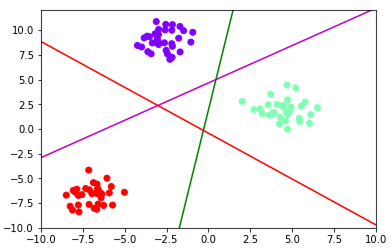

#### Step 1: SparkSession Creation and Library Imports

In [ ]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.classification import LinearSVC
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, VectorIndexer, IndexToString, StringIndexer, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

# Spark Session Creation

ss = SparkSession.builder.master("local[4]").appName("linear-SVC-Regression").getOrCreate()
sc = ss.sparkContext
sqlContext = SQLContext(sc)

#### Step 2: Data Loading and Data Preprocessing

In [ ]:
# Load data from file into dataframe
HOUSING_DATA = 'input/cal_housing.data'
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)
# Load housing data
housing_df = ss.read.csv(path=HOUSING_DATA, schema=schema).cache()

# Inspect first five rows
housing_df.take(5)

# show the dataframe columns
housing_df.columns

# Summary of the data

(housing_df.describe().select(
                    "summary",
                    F.round("medage", 4).alias("medage"),
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv"))
                    .show())


# Adjust the values of `medianHouseValue`
housing_df = housing_df.withColumn("medhv", col("medhv")/100000)


# Add the new columns to `df`
housing_df = (housing_df.withColumn("rmsperhh", F.round(col("totrooms")/col("houshlds"), 2))
                       .withColumn("popperhh", F.round(col("pop")/col("houshlds"), 2))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms")/col("totrooms"), 2)))


## Feature group normalization for binary classification
housing_df = housing_df.withColumn("medhvRounded", F.when((col("medhv") <=3.0), 0).when((col("medhv") > 3.0),1))
housing_df.show(5)

#### Step 3: Feature Selection

In [ ]:
featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage"]

## Indexing creation for the featureCols .. This indexing gives us a mapping. 
indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in featureCols]

# encoder creation
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers]

# Use a VectorAssembler to put features into a feature vector column:
# put features into a feature vector column
assembler = VectorAssembler(inputCols= [encoder.getOutputCol() for encoder in encoders], outputCol="features")
pipeline = Pipeline(stages=indexers + encoders + [assembler])
assembled_df= pipeline.fit(housing_df).transform(housing_df)
assembled_df = assembled_df.withColumn('label', col('medhvRounded'))
assembled_df.show(5, truncate=False)

finalized_df = assembled_df.select("features", "label")
finalized_df.show(n=5)

quality_udf = udf(lambda x: x, StringType())
housing_df = housing_df.withColumn("label", quality_udf("medhvRounded"))

# Re-order and select columns
housing_df = housing_df.select("totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage", "label")


# We need to transform the dataset to Dataframe so that each class can be seperated perfectly.
transformed_df = housing_df.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])
transformed_df.show(5, truncate=False)

#### Step 4: Feature Indexing for Better Classification

In [ ]:
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(transformed_df)
labelIndexer.transform(transformed_df).show(5, True)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=4).fit(transformed_df)
featureIndexer.transform(transformed_df).show(5, True)

#### Step 5: Training and Testing Data Collection

In [ ]:
# Split the data into training and test sets (30% held out for testing)

(train_Data, test_Data) = transformed_df.randomSplit([0.7, 0.3], seed=1234)

train_Data.show(5,False)
test_Data.show(5,False)

#### Step 6: Train the model and Fit the LinearSVC classifier 

In [ ]:
linearSVC = LinearSVC(featuresCol='indexedFeatures', labelCol='indexedLabel')

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, linearSVC,labelConverter])

# Train model.  This also runs the indexers.
linearSVCClassification = pipeline.fit(train_Data)

#### Step 7: Generating Predictions

In [ ]:
predictions = linearSVCClassification.transform(test_Data)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

#### Step 8: Evaluation and Data Classification

In [ ]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = linearSVCClassification.stages[-2]
print(rfModel)

#trainingSummary.roc.show(5)
#print("areaUnderROC: " + str(trainingSummary.areaUnderROC))


from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = []
for i in range(0, len(class_temp)):
    class_names.append(str(class_temp[i]))
class_names

cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
cnf_matrix

plt.figure()
cmap = plt.cm.Blues

plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
plt.title("Random Forest Relation Confussion Matrix")
plt.colorbar()
tick_makers = np.arange(len(class_temp))
plt.xticks(tick_makers, class_temp, rotation=45)
plt.yticks(tick_makers, class_temp)
thresh = cnf_matrix.max() /2
#fmt = '.2f'
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, format(cnf_matrix[i, j]),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.show()

In [ ]:
## Exercise 7

Can we redo the whole process of our highly used Movie Ratings dataset? Can we classify the movies based on their ratings?
Select which features we can use for LinearSVC regression classification. Explain why did you choose them.

# One vs Rest Classifier

OneVsRest is an example of a machine learning reduction for performing multiclass classification given a base classifier that can perform binary classification efficiently. It is also known as “One-vs-All.”

OneVsRest is implemented as an Estimator. For the base classifier, it takes instances of Classifier and creates a binary classification problem for each of the k classes. The classifier for class i is trained to predict whether the label is i or not, distinguishing class i from all other classes.

Predictions are done by evaluating each binary classifier and the index of the most confident classifier is output as label.

One-vs-rest (OvR for short, also referred to as One-vs-All or OvA) is a heuristic method for using binary classification algorithms for multi-class classification.

It involves splitting the multi-class dataset into multiple binary classification problems. A binary classifier is then trained on each binary classification problem and predictions are made using the model that is the most confident.

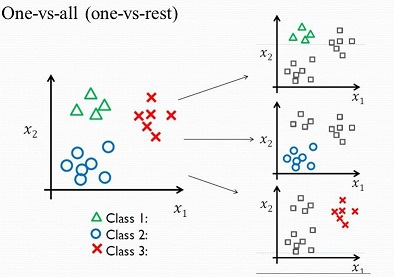

#### Step 1~5: Data Collection and Model Creation

In [ ]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, VectorIndexer, IndexToString, StringIndexer, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

# Spark Session Creation

ss = SparkSession.builder.master("local[4]").appName("linear-SVC-Regression").getOrCreate()
sc = ss.sparkContext
sqlContext = SQLContext(sc)

# Load data from file into dataframe
HOUSING_DATA = 'input/cal_housing.data'
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)
# Load housing data
housing_df = ss.read.csv(path=HOUSING_DATA, schema=schema).cache()

# Inspect first five rows
housing_df.take(5)

# show the dataframe columns
housing_df.columns

# Summary of the data

(housing_df.describe().select(
                    "summary",
                    F.round("medage", 4).alias("medage"),
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv"))
                    .show())


# Adjust the values of `medianHouseValue`
housing_df = housing_df.withColumn("medhv", col("medhv")/100000)


# Add the new columns to `df`
housing_df = (housing_df.withColumn("rmsperhh", F.round(col("totrooms")/col("houshlds"), 2))
                       .withColumn("popperhh", F.round(col("pop")/col("houshlds"), 2))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms")/col("totrooms"), 2)))

## Feature group normalization
housing_df = housing_df.withColumn("medhvRounded", 
                                   F.when((col("medhv") <=1), 0)
                                   .when((col("medhv") <= 2) & (col("medhv") > 1),1)
                                   .when((col("medhv") <= 3) & (col("medhv") > 2),2)
                                   .when((col("medhv") <= 4) & (col("medhv") > 3),3)
                                   .when((col("medhv") > 4),4))
housing_df.show(5)

## Feature Selection

featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage"]

## Indexing creation for the featureCols .. This indexing gives us a mapping. 
indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in featureCols]

# encoder creation
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers]

# Use a VectorAssembler to put features into a feature vector column:
# put features into a feature vector column
assembler = VectorAssembler(inputCols= [encoder.getOutputCol() for encoder in encoders], outputCol="features")
pipeline = Pipeline(stages=indexers + encoders + [assembler])
assembled_df= pipeline.fit(housing_df).transform(housing_df)
assembled_df = assembled_df.withColumn('label', col('medhvRounded'))
assembled_df.show(5, truncate=False)

finalized_df = assembled_df.select("features", "label")
finalized_df.show(n=5)

quality_udf = udf(lambda x: x, StringType())
housing_df = housing_df.withColumn("label", quality_udf("medhvRounded"))

# Re-order and select columns
housing_df = housing_df.select("totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage", "label")


# We need to transform the dataset to Dataframe so that each class can be seperated perfectly.
transformed_df = housing_df.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])
transformed_df.show(5, truncate=False)

# Feature Indexing for Better Classification Mapping

# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(transformed_df)
labelIndexer.transform(transformed_df).show(5, True)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=4).fit(transformed_df)
featureIndexer.transform(transformed_df).show(5, True)

#### Step 6: Train the model and Fit the One-vs-Rest classifier

In [ ]:
# Split the data into training and test sets (30% held out for testing)

(train_Data, test_Data) = transformed_df.randomSplit([0.7, 0.3], seed=1234)

train_Data.show(5,False)
test_Data.show(5,False)

lr = LogisticRegression(featuresCol='indexedFeatures', labelCol='indexedLabel', regParam=0.01, maxIter=200, tol=1E-6, fitIntercept=True)
ovrClassification = OneVsRest(classifier=lr, labelCol='indexedLabel', featuresCol='indexedFeatures')
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, ovrClassification, labelConverter])

# Train model.  This also runs the indexers.
ovrClassification = pipeline.fit(train_Data)

#### Step 7: Generating Predictions

In [ ]:
predictions = ovrClassification.transform(test_Data)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

#### Step 8: Evaluation and Data Classification

In [ ]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = ovrClassification.stages[-2]
print(rfModel)

#trainingSummary.roc.show(5)
#print("areaUnderROC: " + str(trainingSummary.areaUnderROC))


from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = []
for i in range(0, len(class_temp)):
    class_names.append(str(class_temp[i]))
class_names

cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
cnf_matrix

plt.figure()
cmap = plt.cm.Blues

plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
plt.title("Random Forest Relation Confussion Matrix")
plt.colorbar()
tick_makers = np.arange(len(class_temp))
plt.xticks(tick_makers, class_temp, rotation=45)
plt.yticks(tick_makers, class_temp)
thresh = cnf_matrix.max() /2
#fmt = '.2f'
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, format(cnf_matrix[i, j]),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.show()

In [ ]:
## Exercise 8

Can we redo the whole process of our highly used Movie Ratings dataset? Can we classify the movies based on their ratings?
Select which features we can use for One vs Rest classification. Explain why did you choose them.

# Naive Bayes Classifier

Naive Bayes classifiers are a family of simple probabilistic, multiclass classifiers based on applying Bayes’ theorem with strong (naive) independence assumptions between every pair of features.

Naive Bayes can be trained very efficiently. With a single pass over the training data, it computes the conditional probability distribution of each feature given each label. For prediction, it applies Bayes’ theorem to compute the conditional probability distribution of each label given an observation.

MLlib supports Multinomial naive Bayes, Complement naive Bayes, Bernoulli naive Bayes and Gaussian naive Bayes.

Input data: These Multinomial, Complement and Bernoulli models are typically used for document classification. Within that context, each observation is a document and each feature represents a term. A feature’s value is the frequency of the term (in Multinomial or Complement Naive Bayes) or a zero or one indicating whether the term was found in the document (in Bernoulli Naive Bayes). Feature values for Multinomial and Bernoulli models must be non-negative. The model type is selected with an optional parameter “multinomial”, “complement”, “bernoulli” or “gaussian”, with “multinomial” as the default. For document classification, the input feature vectors should usually be sparse vectors. Since the training data is only used once, it is not necessary to cache it.

Additive smoothing can be used by setting the parameter λ (default to 1.0).

In statistics, naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naive) independence assumptions between the features (see Bayes classifier). They are among the simplest Bayesian network models, but coupled with kernel density estimation, they can achieve high accuracy levels.

Naive Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features/predictors) in a learning problem. Maximum-likelihood training can be done by evaluating a closed-form expression, 718  which takes linear time, rather than by expensive iterative approximation as used for many other types of classifiers.

In the statistics literature, naive Bayes models are known under a variety of names, including simple Bayes and independence Bayes. All these names reference the use of Bayes' theorem in the classifier's decision rule, but naive Bayes is not (necessarily) a Bayesian method.

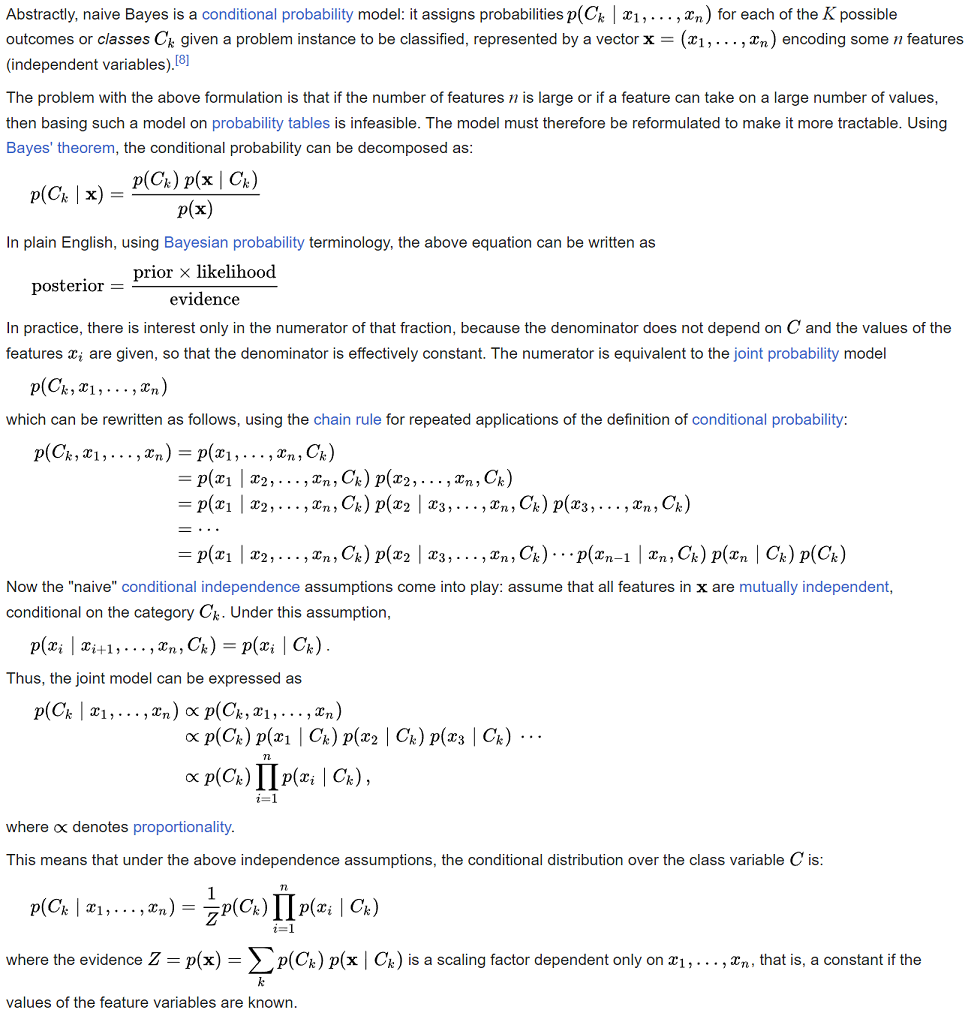

#### Step 6 Train the Model and Fit the Naive Bayes Classifier

In [179]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(featuresCol='indexedFeatures', labelCol='indexedLabel', smoothing=1.0, modelType="multinomial" )

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, nb,labelConverter])

# Train model.  This also runs the indexers.
nbClassification = pipeline.fit(train_Data)

#### Step 7: Generating Predictions

In [180]:
predictions = ovrClassification.transform(test_Data)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

NameError: name 'ovrClassification' is not defined

#### Step 8: Evaluation and Data Classification

In [ ]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = ovrClassification.stages[-2]
print(rfModel)

#trainingSummary.roc.show(5)
#print("areaUnderROC: " + str(trainingSummary.areaUnderROC))


from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = []
for i in range(0, len(class_temp)):
    class_names.append(str(class_temp[i]))
class_names

cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
cnf_matrix

plt.figure()
cmap = plt.cm.Blues

plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
plt.title("Random Forest Relation Confussion Matrix")
plt.colorbar()
tick_makers = np.arange(len(class_temp))
plt.xticks(tick_makers, class_temp, rotation=45)
plt.yticks(tick_makers, class_temp)
thresh = cnf_matrix.max() /2
#fmt = '.2f'
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, format(cnf_matrix[i, j]),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.show()

## Exercise 9

Can we redo the whole process of our highly used Movie Ratings dataset? Can we classify the movies based on their ratings?
Select which features we can use for NAIVE Bayes classification. Explain why did you choose them.

In [181]:
from pyspark.ml.classification import NaiveBayes
moviesDF = ss.read.csv("Movies/movies.csv", header=True, inferSchema=True).cache()
ratingsDF = ss.read.csv("Movies/ratings.csv", header=True, inferSchema=True).cache()

joinedDF = moviesDF.join(ratingsDF, "movieId")

# Inspect first five rows
joinedDF.take(5)

# show the dataframe columns
joinedDF.columns

# Summary of the data

(joinedDF.describe().select(
                    "summary",
                    F.round("rating", 4).alias("rating"))
                    .show())

joinedDF = joinedDF.withColumn("ratingRounded", 
                                   F.when((col("rating") <= 1), 1)
                                   .when((col("rating") <= 2) & (col("rating") > 1), 2)
                                   .when((col("rating") <= 3) & (col("rating") > 2), 3)
                                   .when((col("rating") <= 4) & (col("rating") > 3), 4)
                                   .when((col("rating") > 4), 5))
joinedDF.show(5, truncate=False)

featureCols = ["movieId", "rating"]

indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in featureCols]
# encoder creation
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers]

# Use a VectorAssembler to put features into a feature vector column:
# put features into a feature vector column
assembler = VectorAssembler(inputCols= [encoder.getOutputCol() for encoder in encoders], outputCol="features")
pipeline = Pipeline(stages=indexers + encoders + [assembler])
joinedDF= pipeline.fit(joinedDF).transform(joinedDF)
joinedDF = joinedDF.withColumn('label', col('ratingRounded'))
joinedDF.show(5, truncate=False)

finalized_df = joinedDF.select("features", "label")
finalized_df.show(n=5)

quality_udf = udf(lambda x: x, StringType())
joinedDF = joinedDF.withColumn("label", quality_udf("ratingRounded"))

# Re-order and select columns
joinedDF = joinedDF.select("userId", "rating", "label")
joinedDF.show()

# We need to transform the dataset to Dataframe so that each class can be seperated perfectly.
joinedDF = joinedDF.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])
joinedDF.show(5, truncate=False)

# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(joinedDF)
labelIndexer.transform(joinedDF).show(5, True)

featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=5).fit(joinedDF)
featureIndexer.transform(joinedDF).show(5, True)


(train_Data, test_Data) = joinedDF.randomSplit([0.7, 0.3], seed=1234)

train_Data.show(5,False)
test_Data.show(5,False)

deccls = DecisionTreeClassifier(featuresCol='indexedFeatures', labelCol='indexedLabel')

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, deccls,labelConverter])

# Train model.  This also runs the indexers.
decisionTreeClassification = pipeline.fit(train_Data)


[Row(movieId=1, title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy', userId=1, rating=4.0, timestamp=964982703),
 Row(movieId=3, title='Grumpier Old Men (1995)', genres='Comedy|Romance', userId=1, rating=4.0, timestamp=964981247),
 Row(movieId=6, title='Heat (1995)', genres='Action|Crime|Thriller', userId=1, rating=4.0, timestamp=964982224),
 Row(movieId=47, title='Seven (a.k.a. Se7en) (1995)', genres='Mystery|Thriller', userId=1, rating=5.0, timestamp=964983815),
 Row(movieId=50, title='Usual Suspects, The (1995)', genres='Crime|Mystery|Thriller', userId=1, rating=5.0, timestamp=964982931)]

['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp']

+-------+--------+
|summary|  rating|
+-------+--------+
|  count|100836.0|
|   mean|  3.5016|
| stddev|  1.0425|
|    min|     0.5|
|    max|     5.0|
+-------+--------+

+-------+---------------------------+-------------------------------------------+------+------+---------+-------------+
|movieId|title                      |genres                                     |userId|rating|timestamp|ratingRounded|
+-------+---------------------------+-------------------------------------------+------+------+---------+-------------+
|1      |Toy Story (1995)           |Adventure|Animation|Children|Comedy|Fantasy|1     |4.0   |964982703|4            |
|3      |Grumpier Old Men (1995)    |Comedy|Romance                             |1     |4.0   |964981247|4            |
|6      |Heat (1995)                |Action|Crime|Thriller                      |1     |4.0   |964982224|4            |
|47     |Seven (a.k.a. Se7en) (1995)|Mystery|Thriller                           |1     |5.0   |964983815|5  

In [182]:
nb = NaiveBayes(featuresCol='indexedFeatures', labelCol='indexedLabel', smoothing=1.0, modelType="multinomial" )

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, nb,labelConverter])

# Train model.  This also runs the indexers.
nbClassification = pipeline.fit(train_Data)

In [183]:
predictions = decisionTreeClassification.transform(test_Data)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+---------+-----+--------------+
| features|label|predictedLabel|
+---------+-----+--------------+
|[1.0,1.0]|    1|             1|
|[1.0,2.0]|    2|             2|
|[1.0,2.0]|    2|             2|
|[1.0,3.0]|    3|             3|
|[1.0,3.0]|    3|             3|
+---------+-----+--------------+
only showing top 5 rows



Test Error = 0
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_d93988771f25, depth=3, numNodes=9, numClasses=5, numFeatures=2


['4', '3', '5', '2', '1']

array([[11818,     0,     0,     0,     0],
       [    0,  7696,     0,     0,     0],
       [    0,     0,  6538,     0,     0],
       [    0,     0,     0,  2798,     0],
       [    0,     0,     0,     0,  1231]])

<Figure size 1800x400 with 0 Axes>

Text(0.5, 1.0, 'Random Forest Relation Confussion Matrix')

([<matplotlib.axis.XTick at 0x7fe5425c6140>,
 [Text(0, 0, '4'),
  Text(1, 0, '3'),
  Text(2, 0, '5'),
  Text(3, 0, '2'),
  Text(4, 0, '1')])

([<matplotlib.axis.YTick at 0x7fe5425c6ce0>,
 [Text(0, 0, '4'),
  Text(0, 1, '3'),
  Text(0, 2, '5'),
  Text(0, 3, '2'),
  Text(0, 4, '1')])

Text(0, 0, '11818')

Text(1004.5000000000002, 0.5, 'True label')

Text(0.5, 7.749107165632944, 'Predicted label')

Text(1, 0, '0')

Text(1087.728670612145, 0.5, 'True label')

Text(0.5, 12.44444444444443, 'Predicted label')

Text(2, 0, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 0, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 0, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 1, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 1, '7696')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 1, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 1, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 1, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 2, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 2, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 2, '6538')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 2, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 2, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 3, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 3, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 3, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 3, '2798')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 3, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 4, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 4, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 4, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 4, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 4, '1231')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

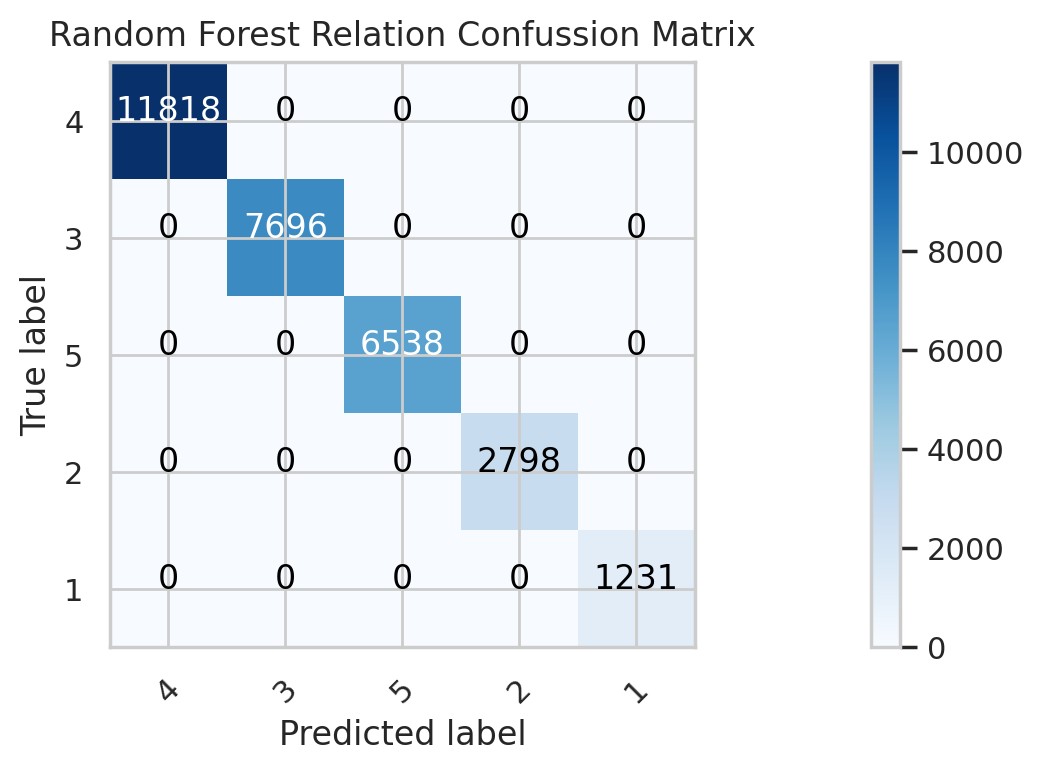

In [184]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = decisionTreeClassification.stages[-2]
print(rfModel)

#trainingSummary.roc.show(5)
#print("areaUnderROC: " + str(trainingSummary.areaUnderROC))


from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = []
for i in range(0, len(class_temp)):
    class_names.append(str(class_temp[i]))
class_names

cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
cnf_matrix

plt.figure()
cmap = plt.cm.Blues

plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
plt.title("Random Forest Relation Confussion Matrix")
plt.colorbar()
tick_makers = np.arange(len(class_temp))
plt.xticks(tick_makers, class_temp, rotation=45)
plt.yticks(tick_makers, class_temp)
thresh = cnf_matrix.max() /2
#fmt = '.2f'
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, format(cnf_matrix[i, j]),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.show()

I just reused the same features I used in the decision tree regression model